<a href="https://www.kaggle.com/code/ehsantaheri/brats20-unet-tumorsegmentation?scriptVersionId=217608368" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [ ]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps  


# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt



# ml libs
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
 


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [ ]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
print(tf.test.is_built_with_cuda())
print(tf.test.is_built_with_gpu_support())
print(tf.test.gpu_device_name())

In [ ]:
import nibabel as nib
import matplotlib.pyplot as plt

TRAIN_DATASET_PATH = '/kaggle/input/brain-tumor-segmentation-in-mri-brats-2015/MICCAI_BraTS2020_TrainingData/'


modalities = ['flair', 't1', 't1ce', 't2']
image_data = {}


for modality in modalities:
    image_data[modality] = nib.load(f'{TRAIN_DATASET_PATH}BraTS20_Training_001/BraTS20_Training_001_{modality}.nii').get_fdata()


test_mask = nib.load(f'{TRAIN_DATASET_PATH}BraTS20_Training_001/BraTS20_Training_001_seg.nii').get_fdata()


#print("Shape of Images ",image_data['flair'].shape)


fig, axes = plt.subplots(1, 5, figsize=(20, 10))
slice_w = 70


titles = ['Image flair', 'Image t1', 'Image t1ce', 'Image t2', 'Mask']


for ax, (modality, title) in zip(axes, zip(modalities, titles)):
    ax.imshow(image_data[modality][:, :, image_data[modality].shape[0] // 2 - slice_w], cmap='gray')
    ax.set_title(title)


axes[4].imshow(test_mask[:, :, test_mask.shape[0] // 2 - slice_w], cmap='gray')

axes[4].set_title('Mask')

plt.show()

In [ ]:

unique_labels = np.unique(test_mask)
print("Unique labels in the mask:", unique_labels)

In [ ]:
print(np.unique(test_mask))  #0, 1, 2, 4 (Need to reencode to 0, 1, 2, 3)
test_mask[test_mask==4] = 3  #Reassign mask values 4 to 3
print(np.unique(test_mask))

In [ ]:

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

slice_index = 70

# Extract the mask slice
mask_slice = test_mask[:, :, slice_index]


class_colors = ['black', 'blue', 'pink', 'cyan'] 
cmap = ListedColormap(class_colors)


class_labels = ['Non-tumor', 'Necrotic/Core', 'Edema', 'Enhancing Tumor']


plt.figure(figsize=(10, 10))
plt.imshow(mask_slice, cmap=cmap)


colorbar = plt.colorbar(ticks=[0, 1, 2, 3])  # Set ticks to match class values
colorbar.set_ticklabels(class_labels)  # Set tick labels to class names

plt.title(f'Mask with 4 Classes (Slice {slice_index})')
plt.axis('off')
plt.show()

In [ ]:


 

# Extract the flair image and mask slices
flair_slice = image_data['flair'][:, :, slice_index]
mask_slice = test_mask[:, :, slice_index]

 
class_colors = ['black', 'blue', 'pink', 'cyan'] 
cmap = ListedColormap(class_colors)

 
plt.figure(figsize=(10, 10))

# Display the flair image
plt.imshow(flair_slice, cmap='gray')

# Overlay the mask with transparency
plt.imshow(mask_slice, cmap=cmap, alpha=0.4)

# Add a colorbar with class labels
colorbar = plt.colorbar(ticks=[0, 1, 2, 3])  # Set ticks to match class values
colorbar.set_ticklabels(['Non-tumor', 'Necrotic/Core', 'Edema', 'Enhancing Tumor'])  # Set tick labels to class names

plt.title(f'Flair Image with Mask Overlay (Slice {slice_index})')
plt.axis('off')
plt.show()

In [ ]:
from nilearn import plotting, image
import nibabel as nib

flair_niimg = nib.load(f"{TRAIN_DATASET_PATH}BraTS20_Training_001/BraTS20_Training_001_flair.nii")
mask_niimg = nib.load(f"{TRAIN_DATASET_PATH}BraTS20_Training_001/BraTS20_Training_001_seg.nii")

 
display = plotting.plot_anat(
    flair_niimg,
    title="Overlay: Flair with Mask",
    display_mode="ortho",  # Displays all three planes (axial, sagittal, coronal)
    dim=-1  
)


display.add_overlay(mask_niimg, cmap="tab10", alpha=0.5)


plotting.show()

In [ ]:



# Stack all modalities along the third axis to create a multi-channel image
combined_modalities = np.stack([image_data['flair'], image_data['t1ce'], image_data['t2']], axis=-1)

# Print shape to verify
print("Shape of combined modalities:", combined_modalities.shape)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assume combined_modalities has shape (240, 240, 155, 3)
modalities = ['Flair', 'T1ce', 'T2']
slice_index = 70

# Plot each modality as a separate panel
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for i, (modality, ax) in enumerate(zip(modalities, axes)):
    # Access the specific slice for each modality
    modality_slice = combined_modalities[:, :, slice_index, i]
    ax.imshow(modality_slice, cmap='gray')
    ax.set_title(modality)
    ax.axis('off')

plt.tight_layout()
plt.show()

# Average all modalities across the 4th axis (channels)
combined_grayscale = np.mean(combined_modalities, axis=-1)

# Display the combined grayscale slice
plt.figure(figsize=(8, 8))
plt.imshow(combined_grayscale[:, :, slice_index], cmap='gray')
plt.title("Combined Modalities (Averaged)")
plt.axis('off')
plt.show()

In [ ]:

for modality in ['flair', 't1ce', 't2']:
    print(f"Shape of {modality} image slice: {image_data[modality].shape}")

print(f"Shape of Combined Modalitiess {combined_modalities.shape}")
print(f"Shape of mask_slice {test_mask.shape}")

In [ ]:

def crop_borders(image, mask, threshold=0):
 
    # Use the middle slice as a reference for cropping
    slice_index = image.shape[2] // 2
    ref_image = np.mean(image[:, :, slice_index, :], axis=-1)  # Averaging across channels for reference

    # Find non-zero pixels (above the threshold) in the reference slice
    rows = np.any(ref_image > threshold, axis=1)
    cols = np.any(ref_image > threshold, axis=0)
    
    # Find bounding box
    row_start, row_end = np.where(rows)[0][[0, -1]]
    col_start, col_end = np.where(cols)[0][[0, -1]]
    
    # Crop the image and mask using the computed boundaries
    cropped_image = image[row_start:row_end + 1, col_start:col_end + 1, :, :]
    cropped_mask = mask[row_start:row_end + 1, col_start:col_end + 1, :]
    
    return cropped_image, cropped_mask

In [ ]:
cropped_combined,cropped_mask=crop_borders(combined_modalities,test_mask)

In [ ]:
from skimage.transform import resize
import numpy as np

# Define the target size
target_size = (128, 128)

# Resize each modality
resized_slices = np.zeros((target_size[0], target_size[1], cropped_combined.shape[2], cropped_combined.shape[3]))

for i in range(cropped_combined.shape[3]):  # Iterate over modalities
    for j in range(cropped_combined.shape[2]):  # Iterate over slices (depth dimension)
        resized_slices[:, :, j, i] = resize(
            cropped_combined[:, :, j, i],
            target_size,
            anti_aliasing=True
        )

# Resize the mask (use nearest neighbor interpolation for class labels)
resized_mask = np.zeros((target_size[0], target_size[1], cropped_mask.shape[2]))

for j in range(cropped_mask.shape[2]):  # Iterate over slices (depth dimension)
    resized_mask[:, :, j] = resize(
        cropped_mask[:, :, j],
        target_size,
        order=0,  # Nearest neighbor interpolation
        preserve_range=True,
        anti_aliasing=False
    )

# Check the resized shapes
print("Shapes after resizing:")
print(f"Resized combined modalities shape: {resized_slices.shape}")
print(f"Resized mask shape: {resized_mask.shape}")

In [ ]:
target_size = (128, 128)
original_depth = 155  # Assuming the original depth is 155 slices
reduced_depth = original_depth - 120 




def preprocess_data(image_data, mask_data, target_size=(128, 128), original_depth=155, reduced_depth=35):
    num_modalities = image_data.shape[3]
    num_classes = 4

    # Remove 20 slices from the beginning and 20 from the end
    image_data = image_data[..., 60:original_depth-60, :]
    mask_data = mask_data[..., 60:original_depth-60]

    # Initialize resized modalities array
    combined_modalities = np.zeros((*target_size, reduced_depth, num_modalities), dtype=np.float32)

    # Resize each slice of each modality
    for i in range(num_modalities):
        for z in range(reduced_depth):  # Process each slice
            combined_modalities[..., z, i] = resize(
                image_data[..., z, i], target_size, mode='reflect', anti_aliasing=True
            )

    # Resize and one-hot encode the mask
    resized_mask = np.zeros((*target_size, reduced_depth), dtype=np.uint8)
    for z in range(reduced_depth):  # Resize each slice of the mask
        resized_mask[..., z] = resize(
            mask_data[..., z], target_size, order=0, preserve_range=True, anti_aliasing=False
        ).astype(np.uint8)

    one_hot_mask = np.zeros((*resized_mask.shape, num_classes), dtype=np.uint8)
    for i, label in enumerate(range(num_classes)):  # Labels in the mask: 0, 1, 2, 3
        one_hot_mask[resized_mask == label, i] = 1

    return combined_modalities, one_hot_mask

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Choose a slice index to visualize
slice_index = 70  # or any index within the range of your mask and combined image

# Plot cropped and resized slices along with the mask
fig, axes = plt.subplots(3, 3, figsize=(20, 15))

modalities = ['flair', 't1ce', 't2']
modality_indices = [0, 1, 2]  # Indices for flair, t1ce, and t2 modalities

# Plot cropped images for each modality
for i, modality_idx in enumerate(modality_indices):
    axes[0, i].imshow(cropped_combined[:, :, slice_index, modality_idx], cmap='gray')
    axes[0, i].set_title(f"Cropped {modalities[i]}")
    axes[0, i].axis('off')

# Plot resized images for each modality
for i, modality_idx in enumerate(modality_indices):
    axes[1, i].imshow(resized_slices[:, :, slice_index, modality_idx], cmap='gray')
    axes[1, i].set_title(f"Resized {modalities[i]}")
    axes[1, i].axis('off')

# Plot cropped mask (select a slice if the mask is 3D, otherwise show the whole image)
axes[2, 0].imshow(cropped_mask[:, :, slice_index], cmap='gray')  # Select a slice if mask is 3D
axes[2, 0].set_title("Cropped Mask")
axes[2, 0].axis('off')

# Plot resized mask (select a slice if the mask is 3D, otherwise show the whole image)
axes[2, 1].imshow(resized_mask[:, :, slice_index], cmap='gray')  # Select a slice if mask is 3D
axes[2, 1].set_title("Resized Mask")
axes[2, 1].axis('off')

# Plot the combined averaged image (slice_index) from resized modalities
# We average the modalities (flair, t1ce, t2) for the selected slice
combined_avg = np.mean(resized_slices[:, :, slice_index, :3], axis=-1)  # Average across flair, t1ce, and t2
axes[2, 2].imshow(combined_avg, cmap='gray')  # Display the combined averaged image
axes[2, 2].set_title("Combined Modalities (Average)")
axes[2, 2].axis('off')

# Hide extra axes in the last row
for ax in axes[2, 3:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Assuming `resized_slices` and `resized_mask` are ready from earlier preprocessing:
combined_modalities, one_hot_mask = preprocess_data(resized_slices, resized_mask)

print("Combined modalities shape:", combined_modalities.shape)  # Should be (H, W, D, modalities)
print("One-hot encoded mask shape:", one_hot_mask.shape)        # Should be (H, W, D, 4)

In [ ]:
from sklearn.model_selection import train_test_split

# Get all patient directories, excluding BraTS20_Training_355
patient_ids = [
    d for d in os.listdir(TRAIN_DATASET_PATH) 
    if os.path.isdir(os.path.join(TRAIN_DATASET_PATH, d)) and d != "BraTS20_Training_355"
]

# Print the patient_ids list

print(f"Found {len(patient_ids)} patient IDs.")

# Split patient IDs into train, validation, and test
train_ids, val_ids = train_test_split(patient_ids, test_size=0.2, random_state=42)
#train_ids, val_ids = train_test_split(train_ids, test_size=0.2, random_state=42)

# Initialize data generators




print(f"Train set size: {len(train_ids)}")
#print(f"Test set size: {len(test_ids)}")
print(f"Validation set size: {len(val_ids)}")
# show number of data for each dir 
def showDataLayout():
    plt.bar(["Train","Valid"],
    [len(train_ids), len(val_ids)], align='center',color=[ 'green','red'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')

    plt.show()
    
showDataLayout()

In [ ]:
import os
import nibabel as nib
import numpy as np
from skimage.transform import resize
from tqdm import tqdm

# Directories to save processed data
train_save_dir = "/kaggle/working/train_data"
val_save_dir = "/kaggle/working/val_data"
dataset_path=TRAIN_DATASET_PATH
# Make directories
os.makedirs(os.path.join(train_save_dir, "images"), exist_ok=True)
os.makedirs(os.path.join(train_save_dir, "masks"), exist_ok=True)
os.makedirs(os.path.join(val_save_dir, "images"), exist_ok=True)
os.makedirs(os.path.join(val_save_dir, "masks"), exist_ok=True)

# List of patient IDs (excluding 355 and ignoring unwanted files)
patient_ids = [p for p in os.listdir(dataset_path) if p.startswith("BraTS20") and p != "BraTS20_Training_355"]

# Split into train and val
split_idx = int(0.8 * len(patient_ids))
train_patients = patient_ids[:split_idx]
val_patients = patient_ids[split_idx:]

def load_and_preprocess_patient(patient_id, save_dir, target_size=(128, 128), num_modalities=3, num_classes=4):
    """Load, preprocess, and save slices for a single patient."""
    patient_path = os.path.join(dataset_path, patient_id)
    modalities = ['flair', 't1ce', 't2'][:num_modalities]
    
    # Load and normalize modalities
    image_data = []
    for modality in modalities:
        modality_path = os.path.join(patient_path, f"{patient_id}_{modality}.nii")
        img = nib.load(modality_path).get_fdata()
        img = (img - np.min(img)) / (np.max(img) - np.min(img))  # Normalize
        image_data.append(img)
    
    # Stack modalities together: (H, W, S, C)
    combined_data = np.stack(image_data, axis=-1)
    
    # Load mask and remap labels
    mask_path = os.path.join(patient_path, f"{patient_id}_seg.nii")
    mask_data = nib.load(mask_path).get_fdata()
    mask_data[mask_data == 4] = 3  # Remap label 4 to 3
    
    # Save slices excluding first and last 60 slices
    num_slices = mask_data.shape[2]
    valid_slices = range(60, num_slices - 60)
    
    for z_index in tqdm(valid_slices, desc=f"Processing {patient_id}"):
        # Extract slices
        slice_img = combined_data[:, :, z_index, :]
        slice_mask = mask_data[:, :, z_index]
        
        # Resize images and masks
        resized_img = resize(slice_img, (target_size[0], target_size[1]), preserve_range=True, mode='reflect', anti_aliasing=True)
        resized_mask = resize(slice_mask, (target_size[0], target_size[1]), preserve_range=True, mode='reflect', anti_aliasing=True)
        
        # One-hot encode mask
        resized_mask = np.eye(num_classes)[resized_mask.astype(np.int32)]
        
        # Save to disk
        np.save(os.path.join(save_dir, "images", f"{patient_id}_slice{z_index}.npy"), resized_img)
        np.save(os.path.join(save_dir, "masks", f"{patient_id}_slice{z_index}.npy"), resized_mask)

# Process and save train data
for patient in train_patients:
    load_and_preprocess_patient(patient, train_save_dir)

# Process and save validation data
for patient in val_patients:
    load_and_preprocess_patient(patient, val_save_dir)

print("Preprocessing and saving completed successfully!")

In [ ]:


# Define the paths to the saved train and validation data
train_images_path = "/kaggle/working/train_data/images"
train_masks_path = "/kaggle/working/train_data/masks"
val_images_path = "/kaggle/working/val_data/images"
val_masks_path = "/kaggle/working/val_data/masks"

# Count the total number of images in train and val sets
num_train_images = len(os.listdir(train_images_path))
num_val_images = len(os.listdir(val_images_path))

print(f"Number of training images: {num_train_images}")
print(f"Number of validation images: {num_val_images}")

In [ ]:
import random
def visualize_samples(images_path, masks_path, num_samples=5, num_classes=4):
    image_files = sorted(os.listdir(images_path))
    mask_files = sorted(os.listdir(masks_path))

    random_indices = random.sample(range(len(image_files)), num_samples)

    plt.figure(figsize=(15, num_samples * 3))
    for i, idx in enumerate(random_indices):
        # Load image and mask
        img = np.load(os.path.join(images_path, image_files[idx]))
        mask = np.load(os.path.join(masks_path, mask_files[idx]))

        # Convert mask back to single-channel for visualization
        mask_single_channel = np.argmax(mask, axis=-1)

        # Plot image and mask
        plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(img[:, :, 0], cmap='gray')  # Display the first modality
        plt.title(f"Image: {image_files[idx]}")
        plt.axis("off")

        plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(mask_single_channel, cmap='viridis')
        plt.title(f"Mask: {mask_files[idx]}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Visualize random training samples
print("Visualizing training samples:")
visualize_samples(train_images_path, train_masks_path, num_samples=5)

# Visualize random validation samples
print("Visualizing validation samples:")
visualize_samples(val_images_path, val_masks_path, num_samples=5)

In [ ]:
from tensorflow.keras.utils import Sequence

class BrainTumorDataGenerator(Sequence):
    def __init__(self, images_path, masks_path, batch_size=16, shuffle=True):
        self.images_path = images_path
        self.masks_path = masks_path
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.image_files = sorted(os.listdir(images_path))
        self.mask_files = sorted(os.listdir(masks_path))
        self.on_epoch_end()

    def __len__(self):
        """Number of batches per epoch."""
        return int(np.floor(len(self.image_files) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data."""
        batch_image_files = self.image_files[index * self.batch_size:(index + 1) * self.batch_size]
        batch_mask_files = self.mask_files[index * self.batch_size:(index + 1) * self.batch_size]

        images, masks = self.__load_batch(batch_image_files, batch_mask_files)
        return np.array(images), np.array(masks)

    def __load_batch(self, batch_image_files, batch_mask_files):
        """Load a batch of images and masks."""
        images = []
        masks = []

        for img_file, mask_file in zip(batch_image_files, batch_mask_files):
            img = np.load(os.path.join(self.images_path, img_file))
            mask = np.load(os.path.join(self.masks_path, mask_file))
            images.append(img)
            masks.append(mask)

        return images, masks

    def on_epoch_end(self):
        """Shuffle data at the end of each epoch."""
        if self.shuffle:
            combined = list(zip(self.image_files, self.mask_files))
            random.shuffle(combined)
            self.image_files, self.mask_files = zip(*combined)

# Initialize data generators
batch_size = 16
train_generator = BrainTumorDataGenerator(train_images_path, train_masks_path, batch_size=batch_size)
val_generator = BrainTumorDataGenerator(val_images_path, val_masks_path, batch_size=batch_size, shuffle=False)

In [ ]:
import tensorflow.keras.backend as K

def weighted_dice_loss(y_true, y_pred, class_weights):
    """Weighted Dice Loss for imbalanced classes."""
    smooth = 1e-6
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')

    intersection = K.sum(y_true * y_pred, axis=[1, 2])
    union = K.sum(y_true + y_pred, axis=[1, 2])

    dice = (2.0 * intersection + smooth) / (union + smooth)
    weighted_dice = -K.sum(class_weights * dice, axis=-1)
    return K.mean(weighted_dice)

# Example class weights (adjust based on your dataset):
class_weights = np.array([0.45, 0.25, 0.20, 0.20])  # Equal weights for all

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth=1.0):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = K.sum(y_true * y_pred, axis=(1, 2, 3))
    return K.mean((2. * intersection + smooth) / 
                  (K.sum(y_true, axis=(1, 2, 3)) + K.sum(y_pred, axis=(1, 2, 3)) + smooth))
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    y_true = K.cast(y_true, y_pred.dtype)  # Cast y_true to the same dtype as y_pred
    y_true_necrotic = y_true[..., 1]  # Class 1: NECROTIC/CORE
    y_pred_necrotic = y_pred[..., 1]
    intersection = K.sum(K.abs(y_true_necrotic * y_pred_necrotic))
    return (2. * intersection) / (K.sum(K.square(y_true_necrotic)) + K.sum(K.square(y_pred_necrotic)) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    y_true = K.cast(y_true, y_pred.dtype)  # Cast y_true to the same dtype as y_pred
    y_true_edema = y_true[..., 2]  # Class 2: EDEMA
    y_pred_edema = y_pred[..., 2]
    intersection = K.sum(K.abs(y_true_edema * y_pred_edema))
    return (2. * intersection) / (K.sum(K.square(y_true_edema)) + K.sum(K.square(y_pred_edema)) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    y_true = K.cast(y_true, y_pred.dtype)  # Cast y_true to the same dtype as y_pred
    y_true_enhancing = y_true[..., 3]  # Class 3: ENHANCING
    y_pred_enhancing = y_pred[..., 3]
    intersection = K.sum(K.abs(y_true_enhancing * y_pred_enhancing))
    return (2. * intersection) / (K.sum(K.square(y_true_enhancing)) + K.sum(K.square(y_pred_enhancing)) + epsilon)

def precision(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

def sensitivity(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [ ]:
# Import Necessary Libraries
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input, Conv2D, Dropout, BatchNormalization, UpSampling2D, concatenate
from tensorflow.keras.models import Model

# Define the Simplified U-Net Model Architecture
def build_unet(input_shape=(128, 128, 3), num_classes=4):
    inputs = Input(input_shape)
    
    # Encoder: Using EfficientNetB0 as a Backbone
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=inputs)
    
    # Extract Encoder Outputs for Skip Connections
    skip1 = base_model.get_layer('block2a_expand_activation').output  # 64x64
    skip2 = base_model.get_layer('block3a_expand_activation').output  # 32x32
    skip3 = base_model.get_layer('block4a_expand_activation').output  # 16x16
    skip4 = base_model.get_layer('block6a_expand_activation').output  # 8x8
    
    # Bottleneck
    x = base_model.output  # 4x4
    
    # Decoder: Manually Implemented Layers (No Loops)
    # 1st Decoder Block
    x = UpSampling2D()(x)  # Upsample 4x4 -> 8x8
    x = concatenate([x, skip4])  # Add Skip Connection
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    # 2nd Decoder Block
    x = UpSampling2D()(x)  # Upsample 8x8 -> 16x16
    x = concatenate([x, skip3])  # Add Skip Connection
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    # 3rd Decoder Block
    x = UpSampling2D()(x)  # Upsample 16x16 -> 32x32
    x = concatenate([x, skip2])  # Add Skip Connection
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    # 4th Decoder Block
    x = UpSampling2D()(x)  # Upsample 32x32 -> 64x64
    x = concatenate([x, skip1])  # Add Skip Connection
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    # Final Upsampling to Match Input Resolution
    x = UpSampling2D()(x)  # Upsample 64x64 -> 128x128
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    # Output Layer
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(x)  # Final Segmentation Map
    
    # Define the Model
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Create the U-Net Model
input_shape = (128, 128, 3)  # Define your input shape here
num_classes = 4  # Define the number of classes for your segmentation task
model = build_unet(input_shape, num_classes)

In [ ]:
strategy = tf.distribute.MirroredStrategy()

In [ ]:
with strategy.scope():
    model = build_unet(input_shape=(128, 128, 3), num_classes=4)  # Your U-Net model
    model.compile(
        optimizer='adam',
        loss=lambda y_true, y_pred: weighted_dice_loss(y_true, y_pred, class_weights),
        metrics=['accuracy',dice_coef]
    )

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

In [ ]:
print(f"Number of devices: {strategy.num_replicas_in_sync}")

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt

# Define the callback to save the best model
checkpoint = ModelCheckpoint(
    "/kaggle/working/best_model.keras", 
    monitor="val_loss", 
    save_best_only=True, 
    mode="min", 
    verbose=1
)

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss", 
    factor=0.5, 
    patience=3, 
    verbose=1, 
    min_lr=1e-6
)

#model.compile(optimizer='adam', loss=lambda y_true, y_pred: weighted_dice_loss(y_true, y_pred, class_weights), metrics=['accuracy'])
print(f"Number of devices: {strategy.num_replicas_in_sync}")


history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=30,
        callbacks=[checkpoint, lr_scheduler]
        
    )

In [ ]:
model.summary()

In [ ]:
# Visualize training and validation metrics
def plot_training_history(history):
    metrics = ["loss", "accuracy",'dice_coef']
    for metric in metrics:
        plt.plot(history.history[metric], label=f"Train {metric}")
        plt.plot(history.history[f"val_{metric}"], label=f"Validation {metric}")
        plt.title(f"{metric.capitalize()} Over Epochs")
        plt.xlabel("Epochs")
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.show()

plot_training_history(history)

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'history' contains the training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.legend()
plt.show()
plt.plot(history.history['val_accuracy'], label='Validation Accuracy',color='r')
plt.legend()
plt.show()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

In [ ]:
from tensorflow.keras.models import load_model



best_model_path = "/kaggle/working/best_model.keras"
best_model = load_model(best_model_path, safe_mode=False,
                         custom_objects={'weighted_dice_loss': weighted_dice_loss, 
                                         'dice_coef': dice_coef})

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os

def visualize_prediction(model, images_path, masks_path, num_samples=1):

    # Get list of image and mask files
    image_files = sorted(os.listdir(images_path))
    mask_files = sorted(os.listdir(masks_path))
    
    # Randomly select samples
    random_indices = np.random.choice(len(image_files), num_samples, replace=False)
    
    for idx in random_indices:
        # Load image and ground truth mask
        img = np.load(os.path.join(images_path, image_files[idx]))
        true_mask = np.load(os.path.join(masks_path, mask_files[idx]))
        
        # Prepare image for prediction (add batch dimension)
        img_for_pred = np.expand_dims(img, axis=0)
        
        # Make prediction
        pred_mask = model.predict(img_for_pred)[0]
        
        # Create visualization
        plt.figure(figsize=(15, 5))
        
        # Original Image (first modality)
        plt.subplot(1, 3, 1)
        plt.imshow(img[:, :, 0], cmap='gray')
        plt.title('Original Image')
        plt.axis('off')
        
        # Ground Truth Mask
        plt.subplot(1, 3, 2)
        true_mask_single = np.argmax(true_mask, axis=-1)
        plt.imshow(true_mask_single, cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')
        
        # Predicted Mask
        plt.subplot(1, 3, 3)
        pred_mask_single = np.argmax(pred_mask, axis=-1)
        plt.imshow(pred_mask_single, cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()

# Example usage:
# Load the best saved model
best_model_path = "/kaggle/working/best_model.keras"
best_model = tf.keras.models.load_model(
    best_model_path,safe_mode=False, 
    custom_objects={
        'weighted_dice_loss': lambda y_true, y_pred: weighted_dice_loss(y_true, y_pred, class_weights),
        'dice_coef': dice_coef
    }
)

# Paths to validation images and masks
val_images_path = "/kaggle/working/val_data/images"
val_masks_path = "/kaggle/working/val_data/masks"

# Visualize predictions
visualize_prediction(model, val_images_path, val_masks_path, num_samples=5)

# 1-Imports and Basic Setup

Explanation

Standard libraries plus Albumentations for data augmentation.
EfficientNetB0 will be our encoder with partial fine-tuning.
Set a random seed (optional) for more consistent results.

In [1]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import nibabel as nib
from skimage.transform import resize

import tensorflow as tf
from tensorflow.keras.utils import Sequence

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Root dataset path
DATASET_DIR = "/kaggle/input/brain-tumor-segmentation-in-mri-brats-2015/MICCAI_BraTS2020_TrainingData"

# Exclude problematic folder
EXCLUDE_PATIENT = "BraTS20_Training_355"

# Where to save preprocessed .npy slices
SAVE_DIR = "/kaggle/working/preprocessed_data"

# Hyperparameters
IMG_HEIGHT   = 128
IMG_WIDTH    = 128
N_CHANNELS   = 3   # e.g., flair, t1ce, t2
N_CLASSES    = 4   # 0,1,2,3
BATCH_SIZE   = 16


# 2-Create Save Directories

In [2]:
os.makedirs(SAVE_DIR, exist_ok=True)
os.makedirs(os.path.join(SAVE_DIR, "images"), exist_ok=True)
os.makedirs(os.path.join(SAVE_DIR, "masks"), exist_ok=True)

print(f"Created/Verified directories under {SAVE_DIR}.")

Created/Verified directories under /kaggle/working/preprocessed_data.


# 3-Configuration and Directory Listing (Excluding 355)
Explanation

We explicitly filter out BraTS20_Training_355 in our list comprehension.

In [3]:


# List all patient dirs but exclude BraTS20_Training_355
all_patient_dirs = [
    d for d in os.listdir(DATASET_DIR)
    if d.startswith("BraTS20_Training_")
    and os.path.isdir(os.path.join(DATASET_DIR, d))
    and d != "BraTS20_Training_355"  # <-- Exclude patient 355
]

print(f"Found {len(all_patient_dirs)} patient directories (excluding 'BraTS20_Training_355').")

Found 368 patient directories (excluding 'BraTS20_Training_355').


# 4-Cropping the Image Around the Tumor in the Mask



1. Convert the mask to single-channel (via argmax).
2. Find the bounding box of all non-zero voxels (i.e., tumor).
3. Crop the image and mask to that bounding box, optionally adding a margin so you don’t lose context.
4. Finally, resize the cropped result to your network’s input size (e.g. 128×128).

This ensures the model sees mostly relevant tissue instead of huge blank areas of background. This often helps the network focus on small tumor subregions.

In [4]:
import numpy as np
from skimage.transform import resize

def crop_to_tumor(image_3ch, mask_1hot, margin=5, out_size=(128,128)):
    """
    Crops the image and mask around the tumor region.
    
    Args:
      image_3ch: (H, W, 3) float32 array, your MRI slice with 3 channels (flair, t1ce, t2).
      mask_1hot: (H, W, 4) float32 or uint8 array, one-hot with classes 0..3.
      margin:    int, extra padding around the bounding box.
      out_size:  final (height, width) after resizing the crop.
    
    Returns:
      cropped_img, cropped_mask in shape out_size × 3 or out_size × 4 (for mask).
    """
    # Convert mask to single-channel: shape (H, W)
    mask_single = np.argmax(mask_1hot, axis=-1)  # 0..3
    
    # Find all non-zero (tumor) pixels
    tumor_pixels = np.where(mask_single != 0)
    if len(tumor_pixels[0]) == 0:
        # No tumor found, fallback => return original or center crop
        # Here we just return the same (optionally you can handle differently)
        # E.g., skip cropping if there's no tumor
        return (resize(image_3ch, (*out_size, 3), preserve_range=True),
                resize(mask_1hot, (*out_size, 4), preserve_range=True, order=0))
    
    # min/max coords
    min_row, max_row = np.min(tumor_pixels[0]), np.max(tumor_pixels[0])
    min_col, max_col = np.min(tumor_pixels[1]), np.max(tumor_pixels[1])
    
    # Add margin
    min_row = max(0, min_row - margin)
    min_col = max(0, min_col - margin)
    max_row = min(mask_single.shape[0], max_row + margin)
    max_col = min(mask_single.shape[1], max_col + margin)
    
    # Crop
    cropped_img  = image_3ch[min_row:max_row, min_col:max_col, :]
    cropped_mask = mask_1hot[min_row:max_row, min_col:max_col, :]
    
    # Now resize to out_size
    # We do channel by channel for the image
    final_img = np.zeros((*out_size, 3), dtype=np.float32)
    for c in range(3):
        final_img[:,:,c] = resize(cropped_img[:,:,c], out_size, preserve_range=True)
    
    # For mask, we do nearest-neighbor (order=0) to preserve discrete labels
    # shape => out_size × 4
    final_mask = np.zeros((*out_size, 4), dtype=mask_1hot.dtype)
    for c in range(4):
        final_mask[:,:,c] = resize(cropped_mask[:,:,c], out_size, 
                                   preserve_range=True, order=0)
    
    # Return
    return final_img, final_mask

# 5-Offline Preprocessing Function
This function:


1. Loads the 3 .nii files + segmentation.
2. Skip slices with no tumor data but keep 5 blank.
3. Resizes and normalizes each slice.
4. Remaps seg label 4 → 3.
5. Saves each slice as .npy files in SAVE_DIR/images and SAVE_DIR/masks.

In [5]:
import os
import nibabel as nib
import numpy as np
import random
from skimage.transform import resize

def preprocess_and_save(
    patient_id, 
    dataset_path, 
    save_dir, 
    skip_slices=20, 
    margin=5, 
    out_size=(128,128)
):
    """
    Loads flair, t1ce, t2, seg for patient_id.
    Skips first & last `skip_slices`.
    Splits slices into tumor vs. negative.
    Keeps all tumor slices, but only 5 negative slices if more are available.
    Then does min-max normalization, remaps 4->3, one-hot, crops around tumor,
    and saves each slice as .npy in save_dir/images & save_dir/masks.
    """
    # --- 1) Load volumes ---
    patient_path = os.path.join(dataset_path, patient_id)
    
    flair_path = os.path.join(patient_path, f"{patient_id}_flair.nii")
    t1ce_path  = os.path.join(patient_path, f"{patient_id}_t1ce.nii")
    t2_path    = os.path.join(patient_path, f"{patient_id}_t2.nii")
    seg_path   = os.path.join(patient_path, f"{patient_id}_seg.nii")
    
    flair_data = nib.load(flair_path).get_fdata()
    t1ce_data  = nib.load(t1ce_path).get_fdata()
    t2_data    = nib.load(t2_path).get_fdata()
    seg_data   = nib.load(seg_path).get_fdata()
    
    # Re-map label 4->3 in the segmentation
    seg_data[seg_data == 4] = 3
    
    depth = flair_data.shape[2]
    
    # --- 2) Determine valid slices (skip front/back) ---
    start_idx = skip_slices
    end_idx   = depth - skip_slices
    if end_idx <= start_idx:
        # Edge case if skip_slices is large
        print(f"Warning: {patient_id} might have too few slices after skipping.")
        return
    
    # --- 3) Separate into tumor slices vs. negative slices ---
    tumor_slices = []
    negative_slices = []
    
    for z in range(start_idx, end_idx):
        seg_slice = seg_data[:,:,z]
        # If there's any non-zero pixel => tumor slice
        if np.any(seg_slice != 0):
            tumor_slices.append(z)
        else:
            negative_slices.append(z)
    
    # Keep all tumor slices
    # Keep only 5 negative slices (randomly chosen) if we have more than 5
    if len(negative_slices) > 5:
        keep_neg = random.sample(negative_slices, 5)
    else:
        keep_neg = negative_slices
    
    final_slices = sorted(tumor_slices + keep_neg)
    
    # Create directories if needed
    images_save_dir = os.path.join(save_dir, "images")
    masks_save_dir  = os.path.join(save_dir, "masks")
    os.makedirs(images_save_dir, exist_ok=True)
    os.makedirs(masks_save_dir, exist_ok=True)
    
    # --- 4) For each chosen slice, preprocess & save ---
    for z in final_slices:
        # Extract slices
        flair_slice = flair_data[:,:,z]
        t1ce_slice  = t1ce_data[:,:,z]
        t2_slice    = t2_data[:,:,z]
        seg_slice   = seg_data[:,:,z]
        
        # Build 3-channel image
        img_3ch = np.stack([flair_slice, t1ce_slice, t2_slice], axis=-1)
        
        # Min-max normalization
        min_val = np.min(img_3ch)
        max_val = np.max(img_3ch)
        img_3ch = (img_3ch - min_val) / (max_val - min_val + 1e-8)
        
        # Convert segmentation to one-hot (4 classes: 0..3)
        seg_slice = seg_slice.astype(np.uint8)
        H, W = seg_slice.shape
        seg_1hot = np.eye(4)[seg_slice.reshape(-1)].reshape(H, W, 4)
        
        # Crop around tumor using your 'crop_to_tumor' if desired
        # (assuming you have a function crop_to_tumor(img, mask, margin, out_size))
        # If you do not have it or do not want it, remove or adapt the line below.
        cropped_img, cropped_mask = crop_to_tumor(img_3ch, seg_1hot, margin=margin, out_size=out_size)
        
        # Alternatively, if you do not want to crop:
        # resized_img, resized_mask = resize_something(...)
        
        # Save .npy
        slice_name = f"{patient_id}_slice{z}.npy"
        np.save(os.path.join(images_save_dir, slice_name), cropped_img)
        np.save(os.path.join(masks_save_dir,  slice_name), cropped_mask)


# 6-Run Preprocessing for All Patients (Offline)
We iterate over all patient IDs (excluding 355) and run the above function.
This can take a while the first time. But then your training will be faster afterward.

In [6]:
a=0
for pid in all_patient_dirs:
    a+=1
    print(a,"Preprocessing:", pid)
    preprocess_and_save(
        patient_id=pid,
        dataset_path=DATASET_DIR,
        save_dir=SAVE_DIR,
        out_size=(128,128)
    )


print("All patient slices have been preprocessed and saved as .npy!")

1 Preprocessing: BraTS20_Training_083
2 Preprocessing: BraTS20_Training_337
3 Preprocessing: BraTS20_Training_161
4 Preprocessing: BraTS20_Training_198
5 Preprocessing: BraTS20_Training_284
6 Preprocessing: BraTS20_Training_169
7 Preprocessing: BraTS20_Training_157
8 Preprocessing: BraTS20_Training_073
9 Preprocessing: BraTS20_Training_253
10 Preprocessing: BraTS20_Training_026
11 Preprocessing: BraTS20_Training_100
12 Preprocessing: BraTS20_Training_107
13 Preprocessing: BraTS20_Training_245
14 Preprocessing: BraTS20_Training_358
15 Preprocessing: BraTS20_Training_310
16 Preprocessing: BraTS20_Training_205
17 Preprocessing: BraTS20_Training_225
18 Preprocessing: BraTS20_Training_320
19 Preprocessing: BraTS20_Training_162
20 Preprocessing: BraTS20_Training_108
21 Preprocessing: BraTS20_Training_048
22 Preprocessing: BraTS20_Training_218
23 Preprocessing: BraTS20_Training_289
24 Preprocessing: BraTS20_Training_045
25 Preprocessing: BraTS20_Training_334
26 Preprocessing: BraTS20_Training

# 7-Visualize Saved .npy Slices (Post-Preprocessing)
We can pick a random .npy file from the images folder, load the image and mask, and display them

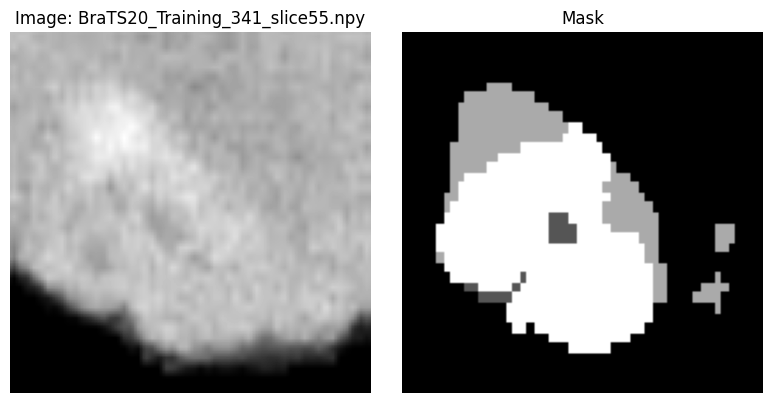

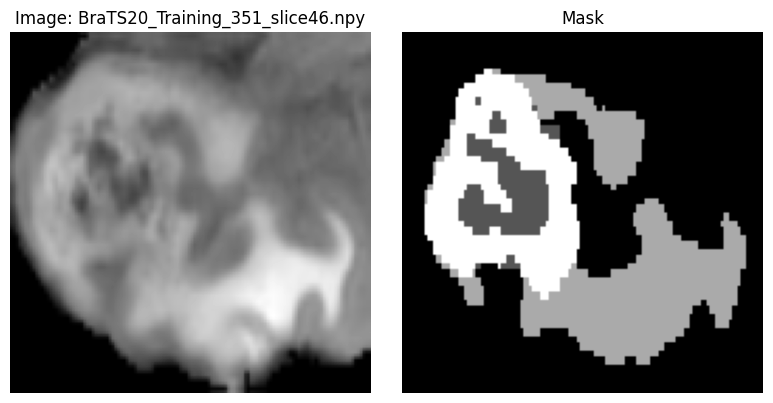

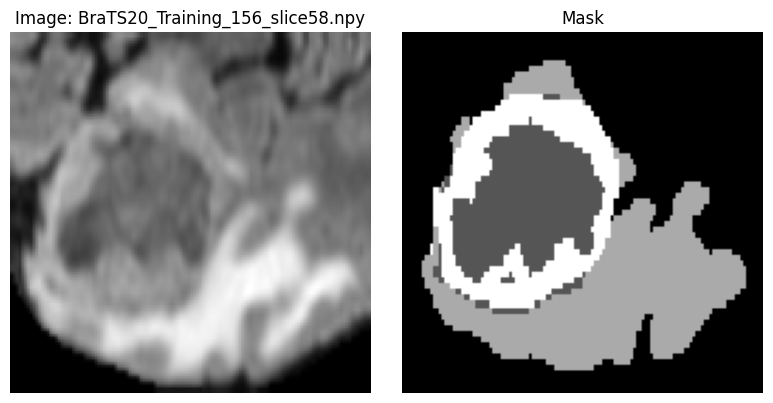

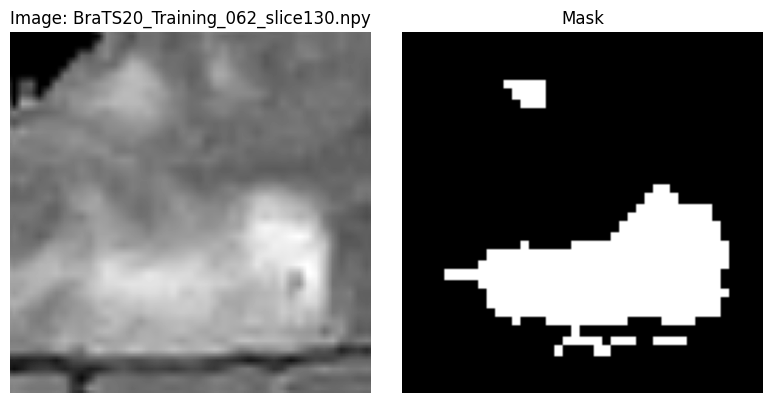

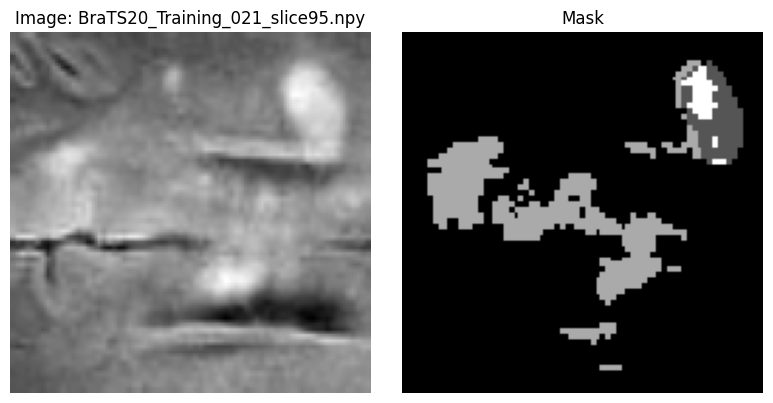

In [11]:
def visualize_npy_slice(images_dir, masks_dir, num_samples=3):
    """
    Randomly pick `num_samples` .npy files from `images_dir`
    and show them alongside their corresponding mask from `masks_dir`.
    """
    image_files = sorted(os.listdir(images_dir))
    if len(image_files) == 0:
        print("No preprocessed files found in", images_dir)
        return
    
    chosen_files = random.sample(image_files, min(num_samples, len(image_files)))
    
    for file_name in chosen_files:
        img_path = os.path.join(images_dir, file_name)
        mask_path= os.path.join(masks_dir, file_name)  # same name, different folder
        
        # Load
        img_3ch   = np.load(img_path)  # shape (128,128,3)
        mask_1hot = np.load(mask_path) # shape (128,128,4)
        
        # Convert mask to single-channel
        mask_sc = np.argmax(mask_1hot, axis=-1)
        
        plt.figure(figsize=(8,4))
        
        # Show 1st channel of the image
        plt.subplot(1,2,1)
        plt.imshow(img_3ch[:,:,0], cmap='gray')
        plt.title(f"Image: {file_name}")
        plt.axis('off')
        
        # Show mask single-channel
        plt.subplot(1,2,2)
        plt.imshow(mask_sc, cmap='gray')
        plt.title("Mask")
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()

visualize_npy_slice(
    images_dir=os.path.join(SAVE_DIR, "images"),
    masks_dir=os.path.join(SAVE_DIR, "masks"),
    num_samples=5
)

# 8-Demonstrate Preprocessing (Normalization & Resize)
Here, we’ll take the same slice from the same patient and show how it looks before vs. after preprocessing steps (min-max normalization + resize to 128×128).


* We pick 5 random files from the preprocessed images folder, load them along with their masks, and show them side by side.
* You can confirm that slices look correct (128×128), that intensities are normalized, and that the mask aligns with the image.

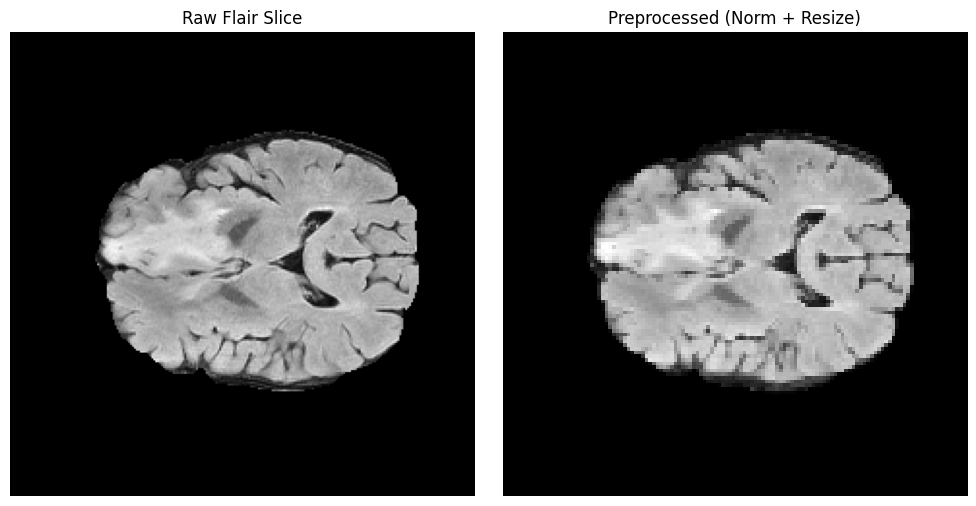

In [12]:
def preprocess_slice(slice_array):
    """Apply min-max normalization and resize to (IMG_HEIGHT, IMG_WIDTH)."""
    min_val, max_val = np.min(slice_array), np.max(slice_array)
    norm_slice = (slice_array - min_val) / (max_val - min_val + 1e-8)
    resized = resize(norm_slice, (IMG_HEIGHT, IMG_WIDTH), preserve_range=True)
    return resized

def show_preprocessing_effect(patient_dir, slice_idx=70):
    flair_path = os.path.join(DATASET_DIR, patient_dir, f"{patient_dir}_flair.nii")
    flair_data = nib.load(flair_path).get_fdata()
    
    # Extract raw slice
    flair_slice_raw = flair_data[:,:,slice_idx]
    
    # Preprocess it
    flair_slice_preproc = preprocess_slice(flair_slice_raw)
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(flair_slice_raw, cmap='gray')
    axes[0].set_title("Raw Flair Slice")
    axes[0].axis('off')
    
    axes[1].imshow(flair_slice_preproc, cmap='gray')
    axes[1].set_title("Preprocessed (Norm + Resize)")
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
sample_patient='BraTS20_Training_298'
show_preprocessing_effect(sample_patient, slice_idx=70)

# 9-Albumentations Setup and Augmentation Visualization
We’ll define an Albumentations pipeline and show how the image and mask look before vs. after augmentation.


1. train_transform: basic flips, rotate90, brightness/contrast for demonstration.
2. augment_slice: converts one-hot -> single channel, applies Albumentations, and converts back to one-hot.
3. demo_augmentation: loads a slice from all 3 modalities + seg, preprocesses them, then calls augment_slice.
4. Displays original vs. augmented in a 2×2 grid.

Sample file chosen for augmentation demo: BraTS20_Training_251_slice92.npy


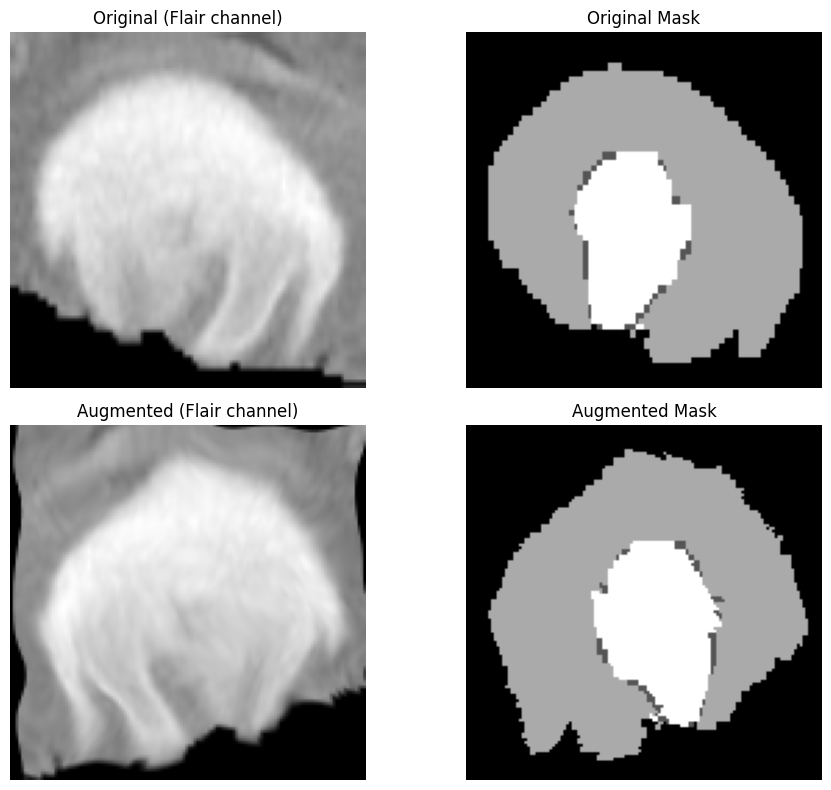

In [15]:
import albumentations as A

IMAGES_DIR = "/kaggle/working/preprocessed_data/images"
MASKS_DIR  = "/kaggle/working/preprocessed_data/masks"

import albumentations as A

advanced_augment_pipeline = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.RandomGamma(gamma_limit=(80, 120), p=0.2), 
    A.ElasticTransform(
        alpha=120, 
        sigma=120 * 0.07, 
        #alpha_affine=120 * 0.03, 
        interpolation=1,
        border_mode=0, 
        p=0.2
    ),
    A.GridDistortion(
        distort_limit=0.2,
        border_mode=0, 
        p=0.2
    )
], p=1.0)


def advanced_augment_npy(image_3ch, mask_1hot):
    mask_sc = np.argmax(mask_1hot, axis=-1).astype(np.uint8)
    augmented = advanced_augment_pipeline(image=image_3ch, mask=mask_sc)
    aug_img  = augmented["image"]
    aug_mask = augmented["mask"]
    aug_mask_1hot = np.eye(mask_1hot.shape[-1])[aug_mask.astype(np.int32)]
    return aug_img, aug_mask_1hot

    
def visualize_augmentation(npy_file):
    """
    Load one .npy image + mask, show them before and after augmentation.
    """
    # Paths
    img_path  = os.path.join(IMAGES_DIR, npy_file)
    mask_path = os.path.join(MASKS_DIR, npy_file)
    
    # Load
    img_3ch  = np.load(img_path)  # (128,128,3)
    mask_1hot= np.load(mask_path) # (128,128,4)
    
    # Convert mask to single-channel for display
    mask_sc  = np.argmax(mask_1hot, axis=-1)
    
    # Augment
    aug_img, aug_mask_1hot = advanced_augment_npy(img_3ch, mask_1hot)
    aug_mask_sc = np.argmax(aug_mask_1hot, axis=-1)
    
    # Show side-by-side
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    
    axes[0,0].imshow(img_3ch[:,:,0], cmap='gray')
    axes[0,0].set_title("Original (Flair channel)")
    axes[0,0].axis('off')
    
    axes[0,1].imshow(mask_sc, cmap='gray')
    axes[0,1].set_title("Original Mask")
    axes[0,1].axis('off')
    
    axes[1,0].imshow(aug_img[:,:,0], cmap='gray')
    axes[1,0].set_title("Augmented (Flair channel)")
    axes[1,0].axis('off')
    
    axes[1,1].imshow(aug_mask_sc, cmap='gray')
    axes[1,1].set_title("Augmented Mask")
    axes[1,1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage:
all_npy_files = sorted(os.listdir(IMAGES_DIR))
if all_npy_files:
    sample_file = random.choice(all_npy_files)
    print("Sample file chosen for augmentation demo:", sample_file)
    visualize_augmentation(sample_file)

# 10-Simple Generator That Loads From .npy Files
Now that we have offline preprocessed slices, we can define a generator that only has to do:


1. Read .npy from disk.
2. (Optionally) apply data augmentation or any additional transformations.
3. Yield (batch_images, batch_masks).

In [16]:

from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split

class NpyDataGenerator(Sequence):
    def __init__(self, 
                 file_list,
                 images_dir,
                 masks_dir,
                 batch_size=8,
                 shuffle=True,
                 augment_fn=None):
        """
        file_list: list of .npy filenames
        images_dir, masks_dir: folders containing matching .npy files
        batch_size: how many slices per batch
        shuffle: whether to shuffle file_list each epoch
        augment_fn: function(image_3ch, mask_1hot)->(aug_image_3ch, aug_mask_1hot)
        """
        self.file_list  = file_list
        self.images_dir = images_dir
        self.masks_dir  = masks_dir
        self.batch_size = batch_size
        self.shuffle    = shuffle
        self.augment_fn = augment_fn
        
        self.on_epoch_end()
    
    def __len__(self):
        return len(self.file_list) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.file_list)
    
    def __getitem__(self, index):
        batch_files = self.file_list[
            index*self.batch_size : (index+1)*self.batch_size
        ]
        
        imgs  = []
        masks = []
        
        for bf in batch_files:
            img_path  = os.path.join(self.images_dir, bf)
            mask_path = os.path.join(self.masks_dir, bf)
            
            image_3ch = np.load(img_path)   # shape (H, W, 3)
            mask_1hot = np.load(mask_path)  # shape (H, W, 4)
            
            if self.augment_fn:
                image_3ch, mask_1hot = self.augment_fn(image_3ch, mask_1hot)
            
            imgs.append(image_3ch)
            masks.append(mask_1hot)
        
        return np.array(imgs, dtype=np.float32), np.array(masks, dtype=np.float32)


all_npy_files = [f for f in os.listdir(IMAGES_DIR) if f.endswith(".npy")]

print("Total files found:", len(all_npy_files))


train_files, val_files = train_test_split(all_npy_files, test_size=0.2, random_state=42)

train_generator = NpyDataGenerator(
    file_list=train_files,
    images_dir=IMAGES_DIR,
    masks_dir=MASKS_DIR,
    batch_size=8,
    shuffle=True,
    augment_fn=advanced_augment_npy  # or None
)

val_generator = NpyDataGenerator(
    file_list=val_files,
    images_dir=IMAGES_DIR,
    masks_dir=MASKS_DIR,
    batch_size=8,
    shuffle=False,
    augment_fn=None
)
print(f"Train slices: {len(train_files)}, Val slices: {len(val_files)}")

Total files found: 26044
Train slices: 20835, Val slices: 5209


# 11-Using Weighted Dice to Address Class Imbalance

We have 4 classes (0..3) but want to penalize mistakes on the smaller tumor classes more, We can define a weighted version:


We multiply each class’s dice by a different weight. For a heavily imbalanced dataset, you might reduce background weight and increase tumor subregion weights.
Tweak class_weights so that the sum can be 1.0 or not—some people keep them unnormalized.

In [17]:
import tensorflow as tf

class_weights = tf.constant([0.02, 0.35, 0.28, 0.36], dtype=tf.float32)
# Example: smaller weight for background (0.05) and heavier weight for tumor subregions
# This depends on your data distribution. Adjust as you see fit.

@tf.function
def weighted_dice_loss(y_true, y_pred, smooth=1e-6):
    """
    Weighted Dice across classes. 
    y_true, y_pred: (batch, H, W, 4) one-hot, float32
    class_weights: shape (4,)
    """
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1,2])
    union        = tf.reduce_sum(y_true + y_pred, axis=[1,2])
    dice_per_class  = (2.0 * intersection + smooth) / (union + smooth)  # (batch, 4)
    
    weighted = dice_per_class * class_weights
    # Average across classes, then average across batch
    dice_score = tf.reduce_mean(weighted, axis=-1)    # shape (batch,)
    loss = 1.0 - tf.reduce_mean(dice_score)
    return loss

# 12-Build a U-Net–Style Model with Pretrained ImageNet Encoder
Here we use EfficientNetB0. We:


1. Load pretrained weights from ImageNet.
2. Grab skip connections to build a simplistic U-Net decoder.
3. Fine tune by freezing some initial layers, unfreezing some.



* We used block2a, block3a, etc. from EfficientNetB0 as skip connections.
* The decoder is a basic upsampling + concatenation approach.
* We freeze the first ~100 layers to preserve the early encoder features (fine-tuning).

In [18]:
strategy = tf.distribute.MirroredStrategy()

In [19]:
from tensorflow.keras.layers import Input, UpSampling2D, concatenate, Dropout, BatchNormalization, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1,2,3])
    denominator  = tf.reduce_sum(y_true, axis=[1,2,3]) + tf.reduce_sum(y_pred, axis=[1,2,3])
    dice = (2.0 * intersection + smooth) / (denominator + smooth)
    return tf.reduce_mean(dice)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coefficient(y_true, y_pred)

def dice_per_class_np(y_true_1hot, y_pred_1hot, smooth=1e-6):
    """
    y_true_1hot, y_pred_1hot: (H, W, 4) or (batch, H, W, 4)
    We'll handle either 3D or 4D by flattening the batch dimension if needed.
    Returns: list of dice [dice_bg, dice_class1, dice_class2, dice_class3]
    """
    if y_true_1hot.ndim == 4:
        # flatten batch dimension
        y_true_1hot = y_true_1hot.reshape(-1, y_true_1hot.shape[-1])
        y_pred_1hot = y_pred_1hot.reshape(-1, y_pred_1hot.shape[-1])
    else:
        # shape (H,W,4)
        y_true_1hot = y_true_1hot.reshape(-1, 4)
        y_pred_1hot = y_pred_1hot.reshape(-1, 4)
    
    dice_scores = []
    for c in range(4):
        intersection = np.sum(y_true_1hot[:, c] * y_pred_1hot[:, c])
        union        = np.sum(y_true_1hot[:, c]) + np.sum(y_pred_1hot[:, c])
        dice_c = (2.*intersection + smooth) / (union + smooth)
        dice_scores.append(dice_c)
    
    return dice_scores



def build_unet_efficientnet(input_shape=(128,128,3), num_classes=4):
        inputs = Input(shape=input_shape)
        
        # Pretrained encoder
        base_model = EfficientNetB0(
            include_top=False,
            weights='imagenet',
            input_tensor=inputs
        )
        
        # Skip connections
        skip1 = base_model.get_layer('block2a_expand_activation').output
        skip2 = base_model.get_layer('block3a_expand_activation').output
        skip3 = base_model.get_layer('block4a_expand_activation').output
        skip4 = base_model.get_layer('block6a_expand_activation').output
        
        # Bottleneck
        x = base_model.output  # ~4x4
        
        # U-Net decoder
        x = UpSampling2D()(x)  # 4->8
        x = concatenate([x, skip4])
        x = Conv2D(256, 3, activation='relu', padding='same')(x)
        x = Dropout(0.2)(x)
        x = BatchNormalization()(x)
        
        x = UpSampling2D()(x)  # 8->16
        x = concatenate([x, skip3])
        x = Conv2D(128, 3, activation='relu', padding='same')(x)
        x = Dropout(0.2)(x)
        x = BatchNormalization()(x)
        
        x = UpSampling2D()(x)  # 16->32
        x = concatenate([x, skip2])
        x = Conv2D(64, 3, activation='relu', padding='same')(x)
        x = Dropout(0.2)(x)
        x = BatchNormalization()(x)
        
        x = UpSampling2D()(x)  # 32->64
        x = concatenate([x, skip1])
        x = Conv2D(32, 3, activation='relu', padding='same')(x)
        x = Dropout(0.2)(x)
        x = BatchNormalization()(x)
        
        x = UpSampling2D()(x)  # 64->128
        x = Conv2D(16, 3, activation='relu', padding='same')(x)
        x = Dropout(0.2)(x)
        x = BatchNormalization()(x)
        
        outputs = Conv2D(num_classes, 1, activation='softmax')(x)
        return Model(inputs, outputs)
with strategy.scope():
    # Build the model
    model = build_unet_efficientnet(
            input_shape=(IMG_HEIGHT, IMG_WIDTH, N_CHANNELS),
            num_classes=N_CLASSES
        )
    
    # --- Freeze layers here BEFORE model.compile ---
    for i, layer in enumerate(model.layers[:200]):
            layer.trainable = False
    
    # Compile with Weighted Dice Loss
    model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
            loss=weighted_dice_loss,     # or focal_tversky_loss, etc.
            metrics=[dice_coefficient]
        )




16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [20]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
from tqdm import tqdm

def dice_per_class_np(y_true_1hot, y_pred_1hot, smooth=1e-6):
    """
    y_true_1hot, y_pred_1hot: (H, W, 4) or (batch, H, W, 4)
    We'll flatten if there's a batch dimension. Returns [dice_bg, dice_class1, dice_class2, dice_class3].
    """
    if y_true_1hot.ndim == 4:  # e.g., (B, H, W, 4)
        y_true_1hot = y_true_1hot.reshape(-1, y_true_1hot.shape[-1])
        y_pred_1hot = y_pred_1hot.reshape(-1, y_pred_1hot.shape[-1])
    else:
        # shape (H, W, 4)
        y_true_1hot = y_true_1hot.reshape(-1, 4)
        y_pred_1hot = y_pred_1hot.reshape(-1, 4)
    
    dice_scores = []
    for c in range(4):
        intersection = np.sum(y_true_1hot[:, c] * y_pred_1hot[:, c])
        union        = np.sum(y_true_1hot[:, c]) + np.sum(y_pred_1hot[:, c])
        dice_c = (2.0 * intersection + smooth) / (union + smooth)
        dice_scores.append(dice_c)
    
    return dice_scores

class PerClassDiceCallback(tf.keras.callbacks.Callback):
    def __init__(self,
                 val_files,
                 images_dir,
                 masks_dir,
                 batch_size=8,
                 num_samples=None):
        super().__init__()
        self.val_files = val_files
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.batch_size = batch_size
        self.num_samples = num_samples
        self._my_model = None


    def on_train_begin(self, logs=None):
        # Keras now has attached the model to `self.model`
        # Let's store it in a private attr so we can reference it:
        self._my_model = self.model

    def on_epoch_end(self, epoch, logs=None):
        # We'll evaluate per-class dice
        files_to_eval = self.val_files
        if self.num_samples is not None:
            import random
            files_to_eval = random.sample(files_to_eval, min(len(files_to_eval), self.num_samples))
        
        dice_scores_list = []

        for f in tqdm(files_to_eval, desc=f"Val Dice (Epoch {epoch+1})", leave=False):
            img_path = os.path.join(self.images_dir, f)
            mask_path= os.path.join(self.masks_dir, f)
            
            image_3ch = np.load(img_path)   # shape (H, W, 3)
            mask_1hot = np.load(mask_path)  # shape (H, W, 4)
            
            # Use self._my_model (the actual model)
            pred = self._my_model.predict(image_3ch[None,...], verbose=0)
            pred_1hot = pred[0]  # shape (H, W, 4)
            
            scores = dice_per_class_np(mask_1hot, pred_1hot)
            dice_scores_list.append(scores)
        
        dice_array = np.array(dice_scores_list)
        mean_scores = dice_array.mean(axis=0)
        print("\n===== Per-Class Dice (Epoch {}) =====".format(epoch+1))
        print(f"Background    = {mean_scores[0]:.4f}")
        print(f"Necrotic/Core = {mean_scores[1]:.4f}")
        print(f"Edema         = {mean_scores[2]:.4f}")
        print(f"Enhancing     = {mean_scores[3]:.4f}")
        print("=====================================")
        
        # optionally add them to logs
        logs["val_dice_bg"] = mean_scores[0]
        logs["val_dice_nec"] = mean_scores[1]
        logs["val_dice_edema"] = mean_scores[2]
        logs["val_dice_enh"] = mean_scores[3]

In [15]:
def focal_tversky_loss(y_true, y_pred, alpha=0.7, gamma=0.75, smooth=1e-6):
    tp = tf.reduce_sum(y_true * y_pred, axis=[1,2,3])
    fn = tf.reduce_sum(y_true * (1 - y_pred), axis=[1,2,3])
    fp = tf.reduce_sum((1 - y_true) * y_pred, axis=[1,2,3])
    tversky_index = (tp + smooth) / (tp + alpha*fn + (1-alpha)*fp + smooth)
    return tf.reduce_mean((1.0 - tversky_index)**gamma)


In [ ]:


epochs_stage1 = 10
callbacks_stage1 = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1),
    tf.keras.callbacks.ModelCheckpoint("/kaggle/working/stage1_model(Weighted_DL).keras", monitor="val_loss", save_best_only=True, verbose=1),
    PerClassDiceCallback(
        val_files=val_files,
        images_dir=IMAGES_DIR,
        masks_dir=MASKS_DIR,
        batch_size=16,
        num_samples=50
    )
]

history1 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs_stage1,
    callbacks=callbacks_stage1
)


for layer in model.layers:
    layer.trainable = True
    
with strategy.scope():
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-7),
        loss=weighted_dice_loss,
        metrics=[dice_coefficient]
    )

epochs_stage2 = 20

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

history2 = model.fit(
    train_generator,
    validation_data=val_generator,
    initial_epoch=epochs_stage1,
    epochs=epochs_stage1 + epochs_stage2,
    callbacks=[
        early_stop,
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1),
        tf.keras.callbacks.ModelCheckpoint("/kaggle/working/stage2_model(Weighted_DL).keras", monitor="val_loss", save_best_only=True, verbose=1),
        PerClassDiceCallback(
            val_files=val_files,
            images_dir=IMAGES_DIR,
            masks_dir=MASKS_DIR,
            batch_size=16,
            num_samples=100  
        )
    ]
)

In [18]:
for i, layer in enumerate(model.layers[:200]):
    layer.trainable = False

epochs_stage1 = 10
callbacks_stage1 = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1),
    tf.keras.callbacks.ModelCheckpoint("stage1_model.keras", monitor="val_loss", save_best_only=True, verbose=1),
    PerClassDiceCallback(
        val_files=val_files,
        images_dir=IMAGES_DIR,
        masks_dir=MASKS_DIR,
        batch_size=8,
        num_samples=50
    )
]

history3 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs_stage1,
    callbacks=callbacks_stage1
)


for layer in model.layers:
    layer.trainable = True
with strategy.scope():
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-7),
        loss=focal_tversky_loss,
        metrics=[dice_coefficient]
    )

epochs_stage2 = 30

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

history4 = model.fit(
    train_generator,
    validation_data=val_generator,
    initial_epoch=epochs_stage1,
    epochs=epochs_stage1 + epochs_stage2,
    callbacks=[
        early_stop,
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1),
        tf.keras.callbacks.ModelCheckpoint("stage2_model.keras", monitor="val_loss", save_best_only=True, verbose=1),
        PerClassDiceCallback(
            val_files=val_files,
            images_dir=IMAGES_DIR,
            masks_dir=MASKS_DIR,
            batch_size=8,
            num_samples=100  
        )
    ]
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2604/2604 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - dice_coefficient: 0.3349 - loss: 0.7358
Epoch 1: val_loss improved from inf to 0.60263, saving model to stage1_model.keras



===== Per-Class Dice (Epoch 1) =====
Background    = 0.7287
Necrotic/Core = 0.1477
Edema         = 0.1661
Enhancing     = 0.1070
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 277s 85ms/step - dice_coefficient: 0.3349 - loss: 0.7358 - val_dice_coefficient: 0.4905 - val_loss: 0.6026 - learning_rate: 1.0000e-06 - val_dice_bg: 0.7287 - val_dice_nec: 0.1477 - val_dice_edema: 0.1661 - val_dice_enh: 0.1070


Epoch 2/10
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - dice_coefficient: 0.4706 - loss: 0.6204
Epoch 2: val_loss improved from 0.60263 to 0.57850, saving model to stage1_model.keras



===== Per-Class Dice (Epoch 2) =====
Background    = 0.7703
Necrotic/Core = 0.1581
Edema         = 0.1688
Enhancing     = 0.1384
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 208s 80ms/step - dice_coefficient: 0.4706 - loss: 0.6204 - val_dice_coefficient: 0.5176 - val_loss: 0.5785 - learning_rate: 1.0000e-06 - val_dice_bg: 0.7703 - val_dice_nec: 0.1581 - val_dice_edema: 0.1688 - val_dice_enh: 0.1384
Epoch 3/10
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - dice_coefficient: 0.5018 - loss: 0.5927
Epoch 3: val_loss improved from 0.57850 to 0.56051, saving model to stage1_model.keras



===== Per-Class Dice (Epoch 3) =====
Background    = 0.7760
Necrotic/Core = 0.1799
Edema         = 0.1570
Enhancing     = 0.1183
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 211s 81ms/step - dice_coefficient: 0.5018 - loss: 0.5927 - val_dice_coefficient: 0.5375 - val_loss: 0.5605 - learning_rate: 1.0000e-06 - val_dice_bg: 0.7760 - val_dice_nec: 0.1799 - val_dice_edema: 0.1570 - val_dice_enh: 0.1183
Epoch 4/10


2604/2604 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - dice_coefficient: 0.5190 - loss: 0.5773
Epoch 4: val_loss improved from 0.56051 to 0.55233, saving model to stage1_model.keras



===== Per-Class Dice (Epoch 4) =====
Background    = 0.7861
Necrotic/Core = 0.1217
Edema         = 0.1666
Enhancing     = 0.0847
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 201s 77ms/step - dice_coefficient: 0.5190 - loss: 0.5773 - val_dice_coefficient: 0.5465 - val_loss: 0.5523 - learning_rate: 1.0000e-06 - val_dice_bg: 0.7861 - val_dice_nec: 0.1217 - val_dice_edema: 0.1666 - val_dice_enh: 0.0847
Epoch 5/10
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - dice_coefficient: 0.5300 - loss: 0.5674
Epoch 5: val_loss improved from 0.55233 to 0.54347, saving model to stage1_model.keras



===== Per-Class Dice (Epoch 5) =====
Background    = 0.7893
Necrotic/Core = 0.1193
Edema         = 0.1868
Enhancing     = 0.1178
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 217s 83ms/step - dice_coefficient: 0.5300 - loss: 0.5674 - val_dice_coefficient: 0.5562 - val_loss: 0.5435 - learning_rate: 1.0000e-06 - val_dice_bg: 0.7893 - val_dice_nec: 0.1193 - val_dice_edema: 0.1868 - val_dice_enh: 0.1178
Epoch 6/10


2604/2604 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - dice_coefficient: 0.5394 - loss: 0.5588
Epoch 6: val_loss improved from 0.54347 to 0.53853, saving model to stage1_model.keras



===== Per-Class Dice (Epoch 6) =====
Background    = 0.7839
Necrotic/Core = 0.1403
Edema         = 0.2031
Enhancing     = 0.1359
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 201s 77ms/step - dice_coefficient: 0.5394 - loss: 0.5588 - val_dice_coefficient: 0.5615 - val_loss: 0.5385 - learning_rate: 1.0000e-06 - val_dice_bg: 0.7839 - val_dice_nec: 0.1403 - val_dice_edema: 0.2031 - val_dice_enh: 0.1359


Epoch 7/10
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - dice_coefficient: 0.5475 - loss: 0.5514
Epoch 7: val_loss improved from 0.53853 to 0.52998, saving model to stage1_model.keras



===== Per-Class Dice (Epoch 7) =====
Background    = 0.7948
Necrotic/Core = 0.1765
Edema         = 0.1982
Enhancing     = 0.0975
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 217s 83ms/step - dice_coefficient: 0.5475 - loss: 0.5514 - val_dice_coefficient: 0.5708 - val_loss: 0.5300 - learning_rate: 1.0000e-06 - val_dice_bg: 0.7948 - val_dice_nec: 0.1765 - val_dice_edema: 0.1982 - val_dice_enh: 0.0975
Epoch 8/10


2604/2604 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - dice_coefficient: 0.5538 - loss: 0.5457
Epoch 8: val_loss improved from 0.52998 to 0.52193, saving model to stage1_model.keras



===== Per-Class Dice (Epoch 8) =====
Background    = 0.7962
Necrotic/Core = 0.1595
Edema         = 0.2167
Enhancing     = 0.1252
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 200s 76ms/step - dice_coefficient: 0.5538 - loss: 0.5457 - val_dice_coefficient: 0.5795 - val_loss: 0.5219 - learning_rate: 1.0000e-06 - val_dice_bg: 0.7962 - val_dice_nec: 0.1595 - val_dice_edema: 0.2167 - val_dice_enh: 0.1252
Epoch 9/10


2604/2604 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - dice_coefficient: 0.5604 - loss: 0.5396
Epoch 9: val_loss improved from 0.52193 to 0.51909, saving model to stage1_model.keras



===== Per-Class Dice (Epoch 9) =====
Background    = 0.8031
Necrotic/Core = 0.1346
Edema         = 0.2724
Enhancing     = 0.0907
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 222s 85ms/step - dice_coefficient: 0.5604 - loss: 0.5396 - val_dice_coefficient: 0.5825 - val_loss: 0.5191 - learning_rate: 1.0000e-06 - val_dice_bg: 0.8031 - val_dice_nec: 0.1346 - val_dice_edema: 0.2724 - val_dice_enh: 0.0907
Epoch 10/10


2604/2604 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - dice_coefficient: 0.5660 - loss: 0.5344
Epoch 10: val_loss improved from 0.51909 to 0.51169, saving model to stage1_model.keras



===== Per-Class Dice (Epoch 10) =====
Background    = 0.7965
Necrotic/Core = 0.1944
Edema         = 0.2566
Enhancing     = 0.1444
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 205s 79ms/step - dice_coefficient: 0.5660 - loss: 0.5344 - val_dice_coefficient: 0.5904 - val_loss: 0.5117 - learning_rate: 1.0000e-06 - val_dice_bg: 0.7965 - val_dice_nec: 0.1944 - val_dice_edema: 0.2566 - val_dice_enh: 0.1444


Epoch 11/40
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - dice_coefficient: 0.4622 - loss: 0.6272
Epoch 11: val_loss improved from inf to 0.55822, saving model to stage2_model.keras



===== Per-Class Dice (Epoch 11) =====
Background    = 0.7260
Necrotic/Core = 0.1237
Edema         = 0.2357
Enhancing     = 0.0898
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 616s 185ms/step - dice_coefficient: 0.4622 - loss: 0.6272 - val_dice_coefficient: 0.5383 - val_loss: 0.5582 - learning_rate: 1.0000e-07 - val_dice_bg: 0.7260 - val_dice_nec: 0.1237 - val_dice_edema: 0.2357 - val_dice_enh: 0.0898


Epoch 12/40
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - dice_coefficient: 0.5116 - loss: 0.5835
Epoch 12: val_loss improved from 0.55822 to 0.52696, saving model to stage2_model.keras



===== Per-Class Dice (Epoch 12) =====
Background    = 0.7565
Necrotic/Core = 0.2206
Edema         = 0.2725
Enhancing     = 0.1777
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 454s 174ms/step - dice_coefficient: 0.5116 - loss: 0.5835 - val_dice_coefficient: 0.5721 - val_loss: 0.5270 - learning_rate: 1.0000e-07 - val_dice_bg: 0.7565 - val_dice_nec: 0.2206 - val_dice_edema: 0.2725 - val_dice_enh: 0.1777
Epoch 13/40


2604/2604 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - dice_coefficient: 0.5374 - loss: 0.5600
Epoch 13: val_loss improved from 0.52696 to 0.50281, saving model to stage2_model.keras



===== Per-Class Dice (Epoch 13) =====
Background    = 0.7870
Necrotic/Core = 0.1625
Edema         = 0.2936
Enhancing     = 0.1720
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 472s 181ms/step - dice_coefficient: 0.5374 - loss: 0.5600 - val_dice_coefficient: 0.5976 - val_loss: 0.5028 - learning_rate: 1.0000e-07 - val_dice_bg: 0.7870 - val_dice_nec: 0.1625 - val_dice_edema: 0.2936 - val_dice_enh: 0.1720
Epoch 14/40
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - dice_coefficient: 0.5528 - loss: 0.5458
Epoch 14: val_loss improved from 0.50281 to 0.48429, saving model to stage2_model.keras



===== Per-Class Dice (Epoch 14) =====
Background    = 0.7930
Necrotic/Core = 0.1860
Edema         = 0.2952
Enhancing     = 0.1498
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 452s 173ms/step - dice_coefficient: 0.5528 - loss: 0.5458 - val_dice_coefficient: 0.6168 - val_loss: 0.4843 - learning_rate: 1.0000e-07 - val_dice_bg: 0.7930 - val_dice_nec: 0.1860 - val_dice_edema: 0.2952 - val_dice_enh: 0.1498
Epoch 15/40


2604/2604 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - dice_coefficient: 0.5645 - loss: 0.5349
Epoch 15: val_loss improved from 0.48429 to 0.47256, saving model to stage2_model.keras



===== Per-Class Dice (Epoch 15) =====
Background    = 0.7992
Necrotic/Core = 0.1820
Edema         = 0.3151
Enhancing     = 0.1458
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 467s 179ms/step - dice_coefficient: 0.5645 - loss: 0.5349 - val_dice_coefficient: 0.6287 - val_loss: 0.4726 - learning_rate: 1.0000e-07 - val_dice_bg: 0.7992 - val_dice_nec: 0.1820 - val_dice_edema: 0.3151 - val_dice_enh: 0.1458
Epoch 16/40


2604/2604 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - dice_coefficient: 0.5730 - loss: 0.5268
Epoch 16: val_loss improved from 0.47256 to 0.46740, saving model to stage2_model.keras



===== Per-Class Dice (Epoch 16) =====
Background    = 0.8043
Necrotic/Core = 0.1591
Edema         = 0.3116
Enhancing     = 0.1854
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 451s 173ms/step - dice_coefficient: 0.5730 - loss: 0.5268 - val_dice_coefficient: 0.6338 - val_loss: 0.4674 - learning_rate: 1.0000e-07 - val_dice_bg: 0.8043 - val_dice_nec: 0.1591 - val_dice_edema: 0.3116 - val_dice_enh: 0.1854
Epoch 17/40


2604/2604 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - dice_coefficient: 0.5808 - loss: 0.5194
Epoch 17: val_loss improved from 0.46740 to 0.45783, saving model to stage2_model.keras



===== Per-Class Dice (Epoch 17) =====
Background    = 0.7981
Necrotic/Core = 0.1739
Edema         = 0.3117
Enhancing     = 0.1755
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 467s 179ms/step - dice_coefficient: 0.5808 - loss: 0.5194 - val_dice_coefficient: 0.6435 - val_loss: 0.4578 - learning_rate: 1.0000e-07 - val_dice_bg: 0.7981 - val_dice_nec: 0.1739 - val_dice_edema: 0.3117 - val_dice_enh: 0.1755
Epoch 18/40


2604/2604 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - dice_coefficient: 0.5864 - loss: 0.5139
Epoch 18: val_loss improved from 0.45783 to 0.45056, saving model to stage2_model.keras



===== Per-Class Dice (Epoch 18) =====
Background    = 0.8253
Necrotic/Core = 0.1938
Edema         = 0.3251
Enhancing     = 0.2238
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 452s 173ms/step - dice_coefficient: 0.5864 - loss: 0.5139 - val_dice_coefficient: 0.6508 - val_loss: 0.4506 - learning_rate: 1.0000e-07 - val_dice_bg: 0.8253 - val_dice_nec: 0.1938 - val_dice_edema: 0.3251 - val_dice_enh: 0.2238
Epoch 19/40


2604/2604 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - dice_coefficient: 0.5922 - loss: 0.5084
Epoch 19: val_loss improved from 0.45056 to 0.44972, saving model to stage2_model.keras



===== Per-Class Dice (Epoch 19) =====
Background    = 0.8234
Necrotic/Core = 0.1343
Edema         = 0.3400
Enhancing     = 0.1897
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 470s 180ms/step - dice_coefficient: 0.5922 - loss: 0.5084 - val_dice_coefficient: 0.6513 - val_loss: 0.4497 - learning_rate: 1.0000e-07 - val_dice_bg: 0.8234 - val_dice_nec: 0.1343 - val_dice_edema: 0.3400 - val_dice_enh: 0.1897
Epoch 20/40
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - dice_coefficient: 0.5961 - loss: 0.5045
Epoch 20: val_loss improved from 0.44972 to 0.44590, saving model to stage2_model.keras



===== Per-Class Dice (Epoch 20) =====
Background    = 0.8132
Necrotic/Core = 0.1763
Edema         = 0.3360
Enhancing     = 0.1890
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 449s 172ms/step - dice_coefficient: 0.5961 - loss: 0.5045 - val_dice_coefficient: 0.6550 - val_loss: 0.4459 - learning_rate: 1.0000e-07 - val_dice_bg: 0.8132 - val_dice_nec: 0.1763 - val_dice_edema: 0.3360 - val_dice_enh: 0.1890
Epoch 21/40
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - dice_coefficient: 0.6012 - loss: 0.4996
Epoch 21: val_loss improved from 0.44590 to 0.44401, saving model to stage2_model.keras



===== Per-Class Dice (Epoch 21) =====
Background    = 0.8253
Necrotic/Core = 0.1990
Edema         = 0.3227
Enhancing     = 0.1710
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 473s 181ms/step - dice_coefficient: 0.6012 - loss: 0.4996 - val_dice_coefficient: 0.6568 - val_loss: 0.4440 - learning_rate: 1.0000e-07 - val_dice_bg: 0.8253 - val_dice_nec: 0.1990 - val_dice_edema: 0.3227 - val_dice_enh: 0.1710
Epoch 22/40


2604/2604 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - dice_coefficient: 0.6028 - loss: 0.4979
Epoch 22: val_loss improved from 0.44401 to 0.43781, saving model to stage2_model.keras



===== Per-Class Dice (Epoch 22) =====
Background    = 0.8290
Necrotic/Core = 0.1636
Edema         = 0.3318
Enhancing     = 0.1648
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 477s 183ms/step - dice_coefficient: 0.6028 - loss: 0.4979 - val_dice_coefficient: 0.6629 - val_loss: 0.4378 - learning_rate: 1.0000e-07 - val_dice_bg: 0.8290 - val_dice_nec: 0.1636 - val_dice_edema: 0.3318 - val_dice_enh: 0.1648
Epoch 23/40
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - dice_coefficient: 0.6078 - loss: 0.4930
Epoch 23: val_loss improved from 0.43781 to 0.43536, saving model to stage2_model.keras



===== Per-Class Dice (Epoch 23) =====
Background    = 0.8149
Necrotic/Core = 0.1876
Edema         = 0.3576
Enhancing     = 0.1991
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 489s 188ms/step - dice_coefficient: 0.6078 - loss: 0.4930 - val_dice_coefficient: 0.6655 - val_loss: 0.4354 - learning_rate: 1.0000e-07 - val_dice_bg: 0.8149 - val_dice_nec: 0.1876 - val_dice_edema: 0.3576 - val_dice_enh: 0.1991
Epoch 24/40


2604/2604 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - dice_coefficient: 0.6109 - loss: 0.4900
Epoch 24: val_loss improved from 0.43536 to 0.43323, saving model to stage2_model.keras



===== Per-Class Dice (Epoch 24) =====
Background    = 0.8299
Necrotic/Core = 0.1994
Edema         = 0.3709
Enhancing     = 0.2014
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 470s 180ms/step - dice_coefficient: 0.6109 - loss: 0.4900 - val_dice_coefficient: 0.6674 - val_loss: 0.4332 - learning_rate: 1.0000e-07 - val_dice_bg: 0.8299 - val_dice_nec: 0.1994 - val_dice_edema: 0.3709 - val_dice_enh: 0.2014
Epoch 25/40
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - dice_coefficient: 0.6124 - loss: 0.4885
Epoch 25: val_loss improved from 0.43323 to 0.42390, saving model to stage2_model.keras



===== Per-Class Dice (Epoch 25) =====
Background    = 0.8462
Necrotic/Core = 0.1699
Edema         = 0.3675
Enhancing     = 0.1875
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 495s 190ms/step - dice_coefficient: 0.6124 - loss: 0.4885 - val_dice_coefficient: 0.6767 - val_loss: 0.4239 - learning_rate: 1.0000e-07 - val_dice_bg: 0.8462 - val_dice_nec: 0.1699 - val_dice_edema: 0.3675 - val_dice_enh: 0.1875
Epoch 26/40


2604/2604 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - dice_coefficient: 0.6154 - loss: 0.4855
Epoch 26: val_loss did not improve from 0.42390



===== Per-Class Dice (Epoch 26) =====
Background    = 0.8385
Necrotic/Core = 0.1586
Edema         = 0.3503
Enhancing     = 0.2357
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 488s 187ms/step - dice_coefficient: 0.6154 - loss: 0.4855 - val_dice_coefficient: 0.6761 - val_loss: 0.4244 - learning_rate: 1.0000e-07 - val_dice_bg: 0.8385 - val_dice_nec: 0.1586 - val_dice_edema: 0.3503 - val_dice_enh: 0.2357
Epoch 27/40
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - dice_coefficient: 0.6182 - loss: 0.4828
Epoch 27: val_loss did not improve from 0.42390



===== Per-Class Dice (Epoch 27) =====
Background    = 0.8353
Necrotic/Core = 0.1788
Edema         = 0.3563
Enhancing     = 0.1895
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 489s 188ms/step - dice_coefficient: 0.6182 - loss: 0.4828 - val_dice_coefficient: 0.6734 - val_loss: 0.4270 - learning_rate: 1.0000e-07 - val_dice_bg: 0.8353 - val_dice_nec: 0.1788 - val_dice_edema: 0.3563 - val_dice_enh: 0.1895
Epoch 28/40
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - dice_coefficient: 0.6212 - loss: 0.4799
Epoch 28: val_loss improved from 0.42390 to 0.41682, saving model to stage2_model.keras



===== Per-Class Dice (Epoch 28) =====
Background    = 0.8266
Necrotic/Core = 0.1906
Edema         = 0.3568
Enhancing     = 0.2269
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 461s 177ms/step - dice_coefficient: 0.6212 - loss: 0.4799 - val_dice_coefficient: 0.6836 - val_loss: 0.4168 - learning_rate: 1.0000e-07 - val_dice_bg: 0.8266 - val_dice_nec: 0.1906 - val_dice_edema: 0.3568 - val_dice_enh: 0.2269
Epoch 29/40


2604/2604 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - dice_coefficient: 0.6231 - loss: 0.4778
Epoch 29: val_loss did not improve from 0.41682



===== Per-Class Dice (Epoch 29) =====
Background    = 0.8417
Necrotic/Core = 0.1699
Edema         = 0.3392
Enhancing     = 0.1820
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 499s 191ms/step - dice_coefficient: 0.6231 - loss: 0.4778 - val_dice_coefficient: 0.6816 - val_loss: 0.4187 - learning_rate: 1.0000e-07 - val_dice_bg: 0.8417 - val_dice_nec: 0.1699 - val_dice_edema: 0.3392 - val_dice_enh: 0.1820
Epoch 30/40


2604/2604 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - dice_coefficient: 0.6249 - loss: 0.4762
Epoch 30: val_loss improved from 0.41682 to 0.41484, saving model to stage2_model.keras



===== Per-Class Dice (Epoch 30) =====
Background    = 0.8420
Necrotic/Core = 0.2184
Edema         = 0.3229
Enhancing     = 0.2315
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 485s 186ms/step - dice_coefficient: 0.6249 - loss: 0.4762 - val_dice_coefficient: 0.6855 - val_loss: 0.4148 - learning_rate: 1.0000e-07 - val_dice_bg: 0.8420 - val_dice_nec: 0.2184 - val_dice_edema: 0.3229 - val_dice_enh: 0.2315
Epoch 31/40


2604/2604 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - dice_coefficient: 0.6272 - loss: 0.4740
Epoch 31: val_loss improved from 0.41484 to 0.41460, saving model to stage2_model.keras



===== Per-Class Dice (Epoch 31) =====
Background    = 0.8355
Necrotic/Core = 0.1742
Edema         = 0.3783
Enhancing     = 0.2452
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 496s 190ms/step - dice_coefficient: 0.6272 - loss: 0.4740 - val_dice_coefficient: 0.6857 - val_loss: 0.4146 - learning_rate: 1.0000e-07 - val_dice_bg: 0.8355 - val_dice_nec: 0.1742 - val_dice_edema: 0.3783 - val_dice_enh: 0.2452


Epoch 32/40
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - dice_coefficient: 0.6301 - loss: 0.4711
Epoch 32: val_loss improved from 0.41460 to 0.40846, saving model to stage2_model.keras



===== Per-Class Dice (Epoch 32) =====
Background    = 0.8441
Necrotic/Core = 0.1960
Edema         = 0.3943
Enhancing     = 0.2245
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 479s 184ms/step - dice_coefficient: 0.6301 - loss: 0.4711 - val_dice_coefficient: 0.6916 - val_loss: 0.4085 - learning_rate: 1.0000e-07 - val_dice_bg: 0.8441 - val_dice_nec: 0.1960 - val_dice_edema: 0.3943 - val_dice_enh: 0.2245
Epoch 33/40


2604/2604 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - dice_coefficient: 0.6312 - loss: 0.4700
Epoch 33: val_loss did not improve from 0.40846



===== Per-Class Dice (Epoch 33) =====
Background    = 0.8396
Necrotic/Core = 0.1400
Edema         = 0.3735
Enhancing     = 0.1538
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 507s 195ms/step - dice_coefficient: 0.6312 - loss: 0.4700 - val_dice_coefficient: 0.6884 - val_loss: 0.4117 - learning_rate: 1.0000e-07 - val_dice_bg: 0.8396 - val_dice_nec: 0.1400 - val_dice_edema: 0.3735 - val_dice_enh: 0.1538
Epoch 34/40
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - dice_coefficient: 0.6335 - loss: 0.4678
Epoch 34: val_loss improved from 0.40846 to 0.40488, saving model to stage2_model.keras



===== Per-Class Dice (Epoch 34) =====
Background    = 0.8506
Necrotic/Core = 0.1430
Edema         = 0.4193
Enhancing     = 0.1639
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 459s 176ms/step - dice_coefficient: 0.6335 - loss: 0.4678 - val_dice_coefficient: 0.6953 - val_loss: 0.4049 - learning_rate: 1.0000e-07 - val_dice_bg: 0.8506 - val_dice_nec: 0.1430 - val_dice_edema: 0.4193 - val_dice_enh: 0.1639
Epoch 35/40
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - dice_coefficient: 0.6348 - loss: 0.4665
Epoch 35: val_loss did not improve from 0.40488



===== Per-Class Dice (Epoch 35) =====
Background    = 0.8435
Necrotic/Core = 0.1646
Edema         = 0.3790
Enhancing     = 0.1897
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 473s 181ms/step - dice_coefficient: 0.6348 - loss: 0.4665 - val_dice_coefficient: 0.6924 - val_loss: 0.4076 - learning_rate: 1.0000e-07 - val_dice_bg: 0.8435 - val_dice_nec: 0.1646 - val_dice_edema: 0.3790 - val_dice_enh: 0.1897
Epoch 36/40


2604/2604 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - dice_coefficient: 0.6369 - loss: 0.4645
Epoch 36: val_loss improved from 0.40488 to 0.40019, saving model to stage2_model.keras



===== Per-Class Dice (Epoch 36) =====
Background    = 0.8379
Necrotic/Core = 0.1837
Edema         = 0.4060
Enhancing     = 0.2486
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 463s 178ms/step - dice_coefficient: 0.6369 - loss: 0.4645 - val_dice_coefficient: 0.6998 - val_loss: 0.4002 - learning_rate: 1.0000e-07 - val_dice_bg: 0.8379 - val_dice_nec: 0.1837 - val_dice_edema: 0.4060 - val_dice_enh: 0.2486


Epoch 37/40
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - dice_coefficient: 0.6393 - loss: 0.4622
Epoch 37: val_loss did not improve from 0.40019



===== Per-Class Dice (Epoch 37) =====
Background    = 0.8535
Necrotic/Core = 0.1832
Edema         = 0.3728
Enhancing     = 0.2295
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 497s 191ms/step - dice_coefficient: 0.6393 - loss: 0.4622 - val_dice_coefficient: 0.6997 - val_loss: 0.4003 - learning_rate: 1.0000e-07 - val_dice_bg: 0.8535 - val_dice_nec: 0.1832 - val_dice_edema: 0.3728 - val_dice_enh: 0.2295
Epoch 38/40


2604/2604 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - dice_coefficient: 0.6398 - loss: 0.4615
Epoch 38: val_loss improved from 0.40019 to 0.39894, saving model to stage2_model.keras



===== Per-Class Dice (Epoch 38) =====
Background    = 0.8399
Necrotic/Core = 0.1687
Edema         = 0.3863
Enhancing     = 0.2375
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 479s 184ms/step - dice_coefficient: 0.6398 - loss: 0.4615 - val_dice_coefficient: 0.7010 - val_loss: 0.3989 - learning_rate: 1.0000e-07 - val_dice_bg: 0.8399 - val_dice_nec: 0.1687 - val_dice_edema: 0.3863 - val_dice_enh: 0.2375
Epoch 39/40
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - dice_coefficient: 0.6431 - loss: 0.4585
Epoch 39: val_loss improved from 0.39894 to 0.39734, saving model to stage2_model.keras



===== Per-Class Dice (Epoch 39) =====
Background    = 0.8538
Necrotic/Core = 0.1639
Edema         = 0.3924
Enhancing     = 0.2362
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 505s 194ms/step - dice_coefficient: 0.6431 - loss: 0.4585 - val_dice_coefficient: 0.7025 - val_loss: 0.3973 - learning_rate: 1.0000e-07 - val_dice_bg: 0.8538 - val_dice_nec: 0.1639 - val_dice_edema: 0.3924 - val_dice_enh: 0.2362
Epoch 40/40


2604/2604 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - dice_coefficient: 0.6440 - loss: 0.4575
Epoch 40: val_loss improved from 0.39734 to 0.39321, saving model to stage2_model.keras



===== Per-Class Dice (Epoch 40) =====
Background    = 0.8325
Necrotic/Core = 0.1835
Edema         = 0.4093
Enhancing     = 0.2219
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 490s 188ms/step - dice_coefficient: 0.6440 - loss: 0.4575 - val_dice_coefficient: 0.7067 - val_loss: 0.3932 - learning_rate: 1.0000e-07 - val_dice_bg: 0.8325 - val_dice_nec: 0.1835 - val_dice_edema: 0.4093 - val_dice_enh: 0.2219
Restoring model weights from the end of the best epoch: 40.


In [65]:

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("/kaggle/working/best_model.keras", 
                                       save_best_only=True, 
                                       monitor="val_loss",
                                       mode="min",
                                       verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", 
                                         factor=0.5, 
                                         patience=3,
                                         min_lr=1e-6,
                                         verbose=1)
]




history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=20,  # or more
        callbacks=callbacks
    )

Epoch 1/20
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - dice_coefficient: 0.4989 - loss: 0.9568
Epoch 1: val_loss improved from inf to 0.94208, saving model to /kaggle/working/best_model.keras
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 143s 73ms/step - dice_coefficient: 0.4989 - loss: 0.9568 - val_dice_coefficient: 0.6520 - val_loss: 0.9421 - learning_rate: 1.0000e-04
Epoch 2/20
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - dice_coefficient: 0.6402 - loss: 0.9462
Epoch 2: val_loss improved from 0.94208 to 0.94060, saving model to /kaggle/working/best_model.keras
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 89s 69ms/step - dice_coefficient: 0.6403 - loss: 0.9462 - val_dice_coefficient: 0.6723 - val_loss: 0.9406 - learning_rate: 1.0000e-04
Epoch 3/20
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - dice_coefficient: 0.6625 - loss: 0.9394
Epoch 3: val_loss improved from 0.94060 to 0.94052, saving model to /kaggle/working/best_model.keras
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 89s 69ms/step - dice_coefficient: 0.6625 - loss:

# 13-Plot Training Curves

In [ ]:
def plot_history(hist):
    plt.figure(figsize=(12,4))
    
    plt.subplot(1,2,1)
    plt.plot(hist.history['loss'], label='Train Loss')
    plt.plot(hist.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title("Loss over Epochs")
    
    plt.subplot(1,2,2)
    plt.plot(hist.history['dice_coefficient'], label='Train Dice')
    plt.plot(hist.history['val_dice_coefficient'], label='Val Dice')
    plt.legend()
    plt.title("Dice over Epochs")
    
    plt.show()

plot_history(history)
print(history.history['val_dice_coefficient'][-1])

In [ ]:
def evaluate_per_class(model, val_files, images_dir, masks_dir, num_samples=None):
    """
    Evaluate per-class dice on the validation set (or subset).
    
    Args:
      model: the trained model.
      val_files: list of .npy filenames for validation.
      images_dir, masks_dir: directories where images/masks are stored.
      num_samples: if None, evaluate all. Otherwise, pick N random files.
    """
    if num_samples is not None:
        # Randomly sample a subset if desired
        val_files = random.sample(val_files, k=min(num_samples, len(val_files)))
    
    dice_scores_list = []  # will collect [BG, Class1, Class2, Class3] for each slice
    
    for f in val_files:
        # Load image + mask
        img_path = os.path.join(images_dir, f)
        mask_path= os.path.join(masks_dir,  f)
        
        image_3ch = np.load(img_path)   # shape (H, W, 3)
        mask_1hot = np.load(mask_path)  # shape (H, W, 4)
        
        # Predict
        pred_1hot = model.predict(image_3ch[None,...])[0]  # (H, W, 4)
        
        # Per-class dice
        scores = dice_per_class_np(mask_1hot, pred_1hot)  # [dice_bg, dice_1, dice_2, dice_3]
        dice_scores_list.append(scores)
    
    dice_array = np.array(dice_scores_list)  # shape (N, 4)
    mean_scores = dice_array.mean(axis=0)
    
    print("===== Per-Class Dice on Validation =====")
    print(f"Background    = {mean_scores[0]:.4f}")
    print(f"Necrotic/Core = {mean_scores[1]:.4f}")
    print(f"Edema         = {mean_scores[2]:.4f}")
    print(f"Enhancing     = {mean_scores[3]:.4f}")
    print("=========================================")


# Example usage, after training:
# Evaluate on entire validation set (which might be large), or pick e.g. 100 slices
evaluate_per_class(
    model,
    val_files,                # from your train_test_split
    os.path.join(SAVE_DIR, "images"),
    os.path.join(SAVE_DIR, "masks"),
    num_samples=100           # or None for entire val set
)


In [44]:
# Then load
best_model = tf.keras.models.load_model(
    "/kaggle/working/best_model.keras",compile=False,
    custom_objects={
        "weighted_dice_loss": weighted_dice_loss,
        "dice_coefficient": dice_coefficient
    }
)

# 14-Load Best Model and Visualize Predictions

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

def visualize_predictions(model, images_dir, masks_dir, num_samples=3):
    """
    Visualize predicted masks vs. ground truth for random slices from .npy files.
    
    Args:
        model: Your trained Keras model (e.g., U-Net).
        images_dir: Directory where .npy image slices (H,W,3) are stored.
        masks_dir:  Directory where .npy mask slices (H,W,4) are stored (same filenames).
        num_samples: How many random slices to visualize.
    """
    # Get a list of .npy files in the images directory
    npy_files = [f for f in os.listdir(images_dir) if f.endswith('.npy')]
    if not npy_files:
        print("No npy files found in", images_dir)
        return
    
    # Randomly pick some files
    chosen_files = random.sample(npy_files, min(num_samples, len(npy_files)))

    for file_name in chosen_files:
        # Load the image and mask
        image_path = os.path.join(images_dir, file_name)
        mask_path  = os.path.join(masks_dir,  file_name)
        
        image_3ch = np.load(image_path)   # shape (H, W, 3)
        mask_1hot = np.load(mask_path)    # shape (H, W, 4)
        
        # Ground truth mask as single-channel
        mask_true_class = np.argmax(mask_1hot, axis=-1)
        
        # Predict
        # Model expects shape (batch, H, W, 3), so expand dims
        pred = model.predict(np.expand_dims(image_3ch, axis=0))  
        # pred shape => (1, H, W, 4)
        pred_mask = pred[0]  # shape (H, W, 4)
        pred_mask_class = np.argmax(pred_mask, axis=-1)  # shape (H, W)
        
        # Plot side by side
        fig, axes = plt.subplots(1, 3, figsize=(14, 4))
        
        # Show one channel of the image, e.g., the first (often Flair)
        axes[0].imshow(image_3ch[:, :, 0], cmap='gray')
        axes[0].set_title("Image (Flair channel)")
        axes[0].axis("off")
        
        # Ground truth
        axes[1].imshow(mask_true_class, cmap='gray')
        axes[1].set_title("Ground Truth Mask")
        axes[1].axis("off")
        
        # Prediction
        axes[2].imshow(pred_mask_class, cmap='gray')
        axes[2].set_title("Predicted Mask")
        axes[2].axis("off")
        
        plt.suptitle(f"File: {file_name}", fontsize=14)
        plt.tight_layout()
        plt.show()

# Example usage:
visualize_predictions(model, "/kaggle/working/preprocessed_data/images", "/kaggle/working/preprocessed_data/masks", num_samples=5)

## Summary
We excluded the folder BraTS20_Training_355 by checking d != "BraTS20_Training_355" in the list comprehension.
We split the rest of the folders into train/validation sets in memory and do not maintain separate train/val directories on disk.
We created a custom generator that loads .nii files on the fly, and optionally applies Albumentations for data augmentation.
We use Dice (and optionally Weighted Dice) for the main segmentation metric.
We demonstrate partial fine-tuning of EfficientNetB0 as a 2D encoder for U-Net.